In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline

import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import warnings
from csv_reader import read_csv
from aux import set_smallest_n_zero
from disp import set_font_size, get_ordered_colors
from copy import deepcopy as copy
from analysis_tools import *
from pathlib import Path
from csv_reader import read_csv
from csv_writer import write_csv
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 2.0

warnings.filterwarnings('ignore')


In [2]:
rule_names = [ # Define labels for all rules to be run during simulations
    r'Const',
    r'$y$',
    r'$x$',
    r'$x \, y$',
    r'$y_{int}$',
    r'$x \, y_{int}$',
    r'$x_{int}$',
    r'$x_{int} \, y$',
    r'$y_{int} \, y$',
    r'$x_{int} \, x$',

    r'$w$',
    r'$w \, y$',
    r'$w \, x$',
    r'$w \, x \, y$',
    r'$w y_{int}$',
    r'$w x \, y_{int}$',
    r'$w x_{int}$',
    r'$w x_{int} \, y$',
    r'$w y_{int} \, y$',
    r'$w x_{int} \, x$',
]

time_constants = [
    r'$\tau \, y_{int}$',
    r'$\tau \, x \, y_{int}$',
    r'$\tau \, x_{int}$',
    r'$\tau \, x_{int} \, y$',
    r'$\tau \, y_{int} \, y$',
    r'$\tau \, x_{int} \, x$',
    
    r'$\tau \, w y_{int}$',
    r'$\tau \, w x \, y_{int}$',
    r'$\tau \, w x_{int}$',
    r'$\tau \, w x_{int} \, y$',
    r'$\tau \, w y_{int} \, y$',
    r'$\tau \, w x_{int} \, x$',
]

general_rule_names = copy(rule_names)

rule_names = [
    [r'$E \rightarrow E$ ' + r_name for r_name in rule_names],
    [r'$E \rightarrow I$ ' + r_name for r_name in rule_names],
    [r'$I \rightarrow E$ ' + r_name for r_name in rule_names],
]
rule_names = np.array(rule_names).flatten()

In [4]:
def calc_entropy(l):
    abs_l = np.abs(l)[np.abs(l) > 0]
    per_l = abs_l / np.sum(abs_l)
    return -np.dot(np.log(per_l), per_l)

def normalize(x):
    x_ = np.array(x)
    x_ = (x_ - np.mean(x_))
    return x_ / np.std(x_)

In [ ]:
file_name = 'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_502_2023-12-28_15:06:01.964623'
saved_weights_path = test_data_path = f'./sims_out/{file_name}/weight_matrices.csv'

all_w = read_csv(saved_weights_path, read_header=False)
weight_mat_side_len = np.sqrt(all_w.shape[1]).astype(int)
print(weight_mat_side_len)
all_w = [np.array(all_w.iloc[i]).reshape((weight_mat_side_len, weight_mat_side_len)) for i in range(all_w.shape[0])]

Summed ee, lag 2 0.30400365324811884
Summed ee, lag 1 0.2657932923218968
Summed ee, lag 0 0.5960398643239309
Summed ie, lag 1 0.2934163594610156
[ 0.02043334 -0.15039804  0.46810116  0.23723947]
0.3937997154238243


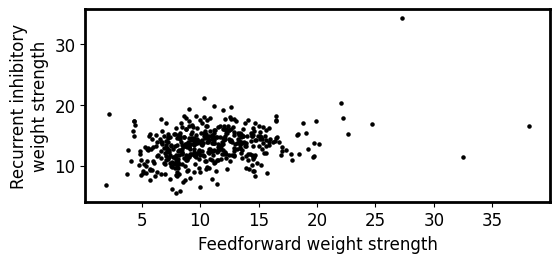

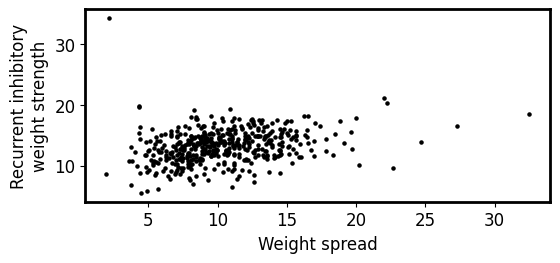

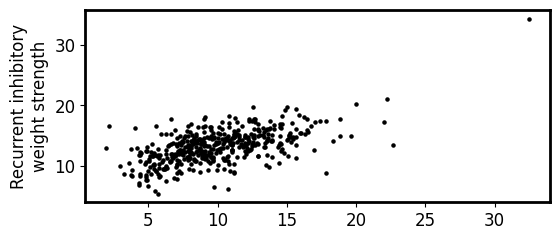

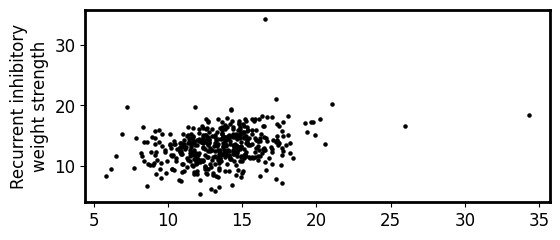

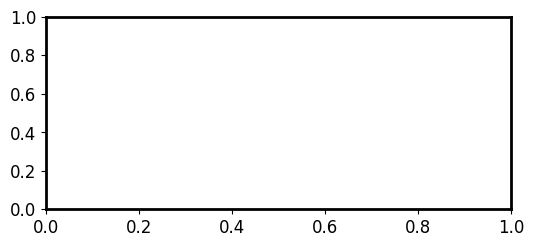

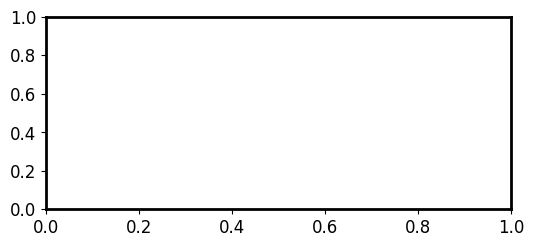

In [256]:
scale = 1
corr_fig, corr_axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_2, corr_axs_2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_3, corr_axs_3 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_inh, corr_axs_inh = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

corr_fig_4, corr_axs_4 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_5, corr_axs_5 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

all_w_ee_summed = []
all_w_ee_summed_lag_1 = []
all_w_ee_summed_lag_2 = []
all_w_ie_summed = []
all_w_ie_summed_lag_1 = []
all_w_ie_summed_lag_2 = []
all_w_count = []
all_w_ee_maxs = []
all_w_ee_spreads = []

for w in all_w:
#     fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    
    w_ee_entropy = np.array([calc_entropy(w[i, :25]) for i in range(25)])
    
    w_ee_summed = w[:25, :25].sum(axis=1)
    w_ee_summed_lag_1 = np.concatenate([w_ee_summed[1:], [np.nan]])
    w_ee_summed_lag_2 = np.concatenate([w_ee_summed[2:], [np.nan, np.nan]])
            
    w_ie_summed = np.zeros(25)
    w_count = np.zeros(25)
    w_ee_max = w[:25, :25].max(axis=1)
    w_ee_spread = np.zeros(25)
    
    
    for i in range(25):
        w_ee_spread[i] = np.sum(np.abs(i - np.arange(25)) * (w[i, :25] / np.sum(w[i, :25])))
        w_count[i] = np.count_nonzero(w[i, np.maximum(i-5, 0):i] > 1e-6, axis=0)
        w_ie_summed[i] = (w[np.maximum(i, 0):np.minimum(25, i+1), 25:]).sum()

        
    w_ie_summed_lag_1 = np.concatenate([w_ie_summed[1:], [np.nan]])
    w_ie_summed_lag_2 = np.concatenate([w_ie_summed[2:], [np.nan, np.nan]])
#     axs.plot(np.arange(25), w_ee_summed, color='red')
#     axs.plot(np.arange(25), np.abs(w_ie_summed), color='blue')
#     axs.plot(np.arange(25), w_count, color='black')
    
    all_w_ee_summed += list(w_ee_summed[5:23])
    all_w_ee_summed_lag_1 += list(np.abs(w_ee_summed_lag_1[5:23]))
    all_w_ee_summed_lag_2 += list(np.abs(w_ee_summed_lag_2[5:23]))
    all_w_ie_summed += list(np.abs(w_ie_summed[5:23]))
    all_w_ie_summed_lag_1 += list(np.abs(w_ie_summed_lag_1[5:23]))
    all_w_ie_summed_lag_2 += list(np.abs(w_ie_summed_lag_2[5:23]))
    all_w_count += list(w_count[5:])
    all_w_ee_maxs += list(w_ee_max[5:] / w_ee_summed[5:])
    all_w_ee_spreads += list(w_ee_spread[5:])

all_w_ee_summed = np.array(all_w_ee_summed)
all_w_ee_summed_lag_1 = np.array(all_w_ee_summed_lag_1)
all_w_ee_summed_lag_2 = np.array(all_w_ee_summed_lag_2)
all_w_ie_summed = np.array(all_w_ie_summed)
all_w_ie_summed_lag_1 = np.array(all_w_ie_summed_lag_1)
all_w_ie_summed_lag_2 = np.array(all_w_ie_summed_lag_2)
corr_axs.scatter(all_w_ee_summed, all_w_ie_summed_lag_2, color='black', s=5)
corr_axs.set_xlabel('Feedforward weight strength')
corr_axs.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed, all_w_ie_summed_lag_2)
print('Summed ee, lag 2', res.rvalue)

# need to control for total synapse strength here

# corr_axs_2.scatter(all_w_count + np.random.normal(size=len(all_w_count), scale=0.1), all_w_ie_summed, color='black', s=5)
# res = linregress(all_w_count, all_w_ie_summed)
# print(res.rvalue)

corr_axs_2.scatter(all_w_ee_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
corr_axs_2.set_xlabel('Weight spread')
corr_axs_2.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed_lag_1, all_w_ie_summed_lag_2)
print('Summed ee, lag 1', res.rvalue)

corr_axs_3.scatter(all_w_ee_summed_lag_2, all_w_ie_summed_lag_2, color='black', s=5)
# corr_axs_3.set_xlabel('Weight spread')
corr_axs_3.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed_lag_2, all_w_ie_summed_lag_2)
print('Summed ee, lag 0', res.rvalue)

corr_axs_inh.scatter(all_w_ie_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
# corr_axs_3.set_xlabel('Weight spread')
corr_axs_inh.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ie_summed_lag_1, all_w_ie_summed_lag_2)
print('Summed ie, lag 1', res.rvalue)

# cbar = corr_axs_3.scatter(all_w_ee_summed, all_w_ee_summed_lag_1, c=all_w_ie_summed_lag_1, s=5, cmap='plasma')
# corr_axs_3.set_xlim(0, 25)
# corr_axs_3.set_ylim(0, 25)
# corr_axs_3.set_xlabel('Cov 1')
# corr_axs_3.set_ylabel('Cov 2')
# corr_fig_3.colorbar(cbar)


# corr_axs_4.scatter(all_w_ee_summed * all_w_ee_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
# # corr_axs_4.set_xlabel('Weight spread')
# # corr_axs_4.set_ylabel('Recurrent inhibitory\nweight strength')
# corr_axs_4.set_xlim(0, 500)
# res = linregress(all_w_ee_summed * all_w_ee_summed_lag_1, all_w_ie_summed_lag_2)
# print(res.rvalue)

# corr_axs_5.scatter(all_w_ee_summed_lag_1 * all_w_ee_summed_lag_2, all_w_ie_summed_lag_2, color='black', s=5)
# # corr_axs_4.set_xlabel('Weight spread')
# # corr_axs_4.set_ylabel('Recurrent inhibitory\nweight strength')
# # corr_axs_5.set_xlim(0, 500)
# res = linregress(all_w_ee_summed_lag_1 * all_w_ee_summed_lag_2, all_w_ie_summed_lag_2)
# print(res.rvalue)


# corr_axs_3.set_title('Recurrent inhibitory\nweight strength')

# Todo: fit a model with max synapse size AND total synaptic strength, see if this better correlates?
# evidently not

reg = LinearRegression().fit(np.array([all_w_ee_summed, all_w_ee_summed_lag_1, all_w_ee_summed_lag_2, all_w_ie_summed_lag_1]).T, all_w_ie_summed_lag_2)
print(reg.coef_)
print(reg.score(np.array([all_w_ee_summed, all_w_ee_summed_lag_1, all_w_ee_summed_lag_2, all_w_ie_summed_lag_1]).T, all_w_ie_summed_lag_2))

In [173]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_502_2023-12-28_14:46:45.499087'
saved_weights_path = test_data_path = f'./sims_out/{file_name}/weight_matrices.csv'

all_w = read_csv(saved_weights_path, read_header=False)
weight_mat_side_len = np.sqrt(all_w.shape[1]).astype(int)
print(weight_mat_side_len)
all_w = [np.array(all_w.iloc[i]).reshape((weight_mat_side_len, weight_mat_side_len)) for i in range(all_w.shape[0])]

33


Summed ee, lag 2 0.014120332503881337
Summed ee, lag 1 -0.06039864705314543
Summed ee, lag 0 0.4943751168596442
Summed ie, lag 1 0.09365092177126609
[-0.01051532 -0.04186676  0.0986287   0.2015043 ]
0.29443103277640037


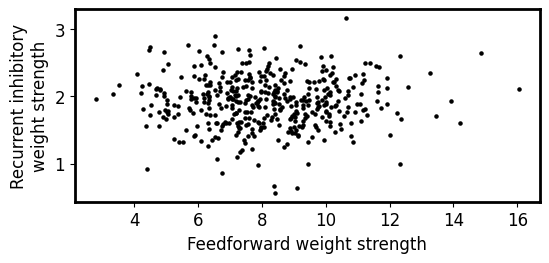

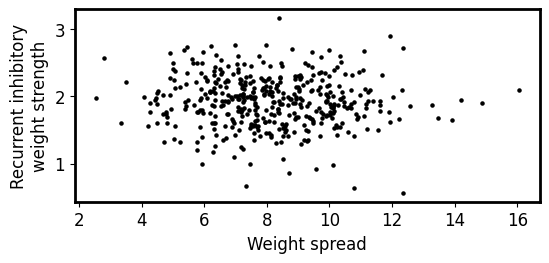

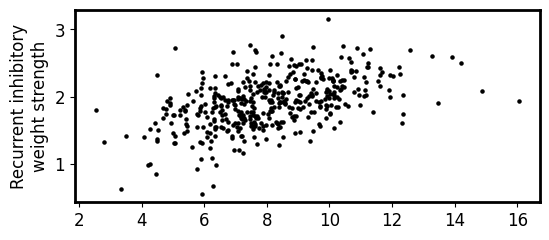

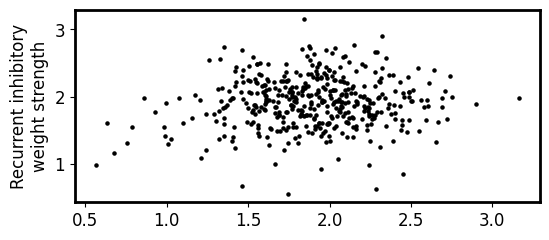

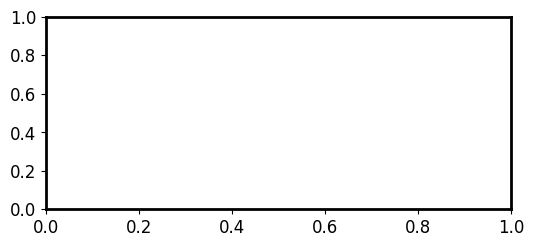

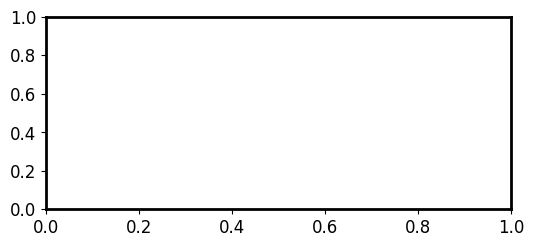

In [174]:
scale = 1
corr_fig, corr_axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_2, corr_axs_2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_3, corr_axs_3 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_inh, corr_axs_inh = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

corr_fig_4, corr_axs_4 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_5, corr_axs_5 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

all_w_ee_summed = []
all_w_ee_summed_lag_1 = []
all_w_ee_summed_lag_2 = []
all_w_ie_summed = []
all_w_ie_summed_lag_1 = []
all_w_ie_summed_lag_2 = []
all_w_count = []
all_w_ee_maxs = []
all_w_ee_spreads = []

for w in all_w:
#     fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    
    w_ee_entropy = np.array([calc_entropy(w[i, :25]) for i in range(25)])
    
    w_ee_summed = w[:25, :25].sum(axis=1)
    w_ee_summed_lag_1 = np.concatenate([w_ee_summed[1:], [np.nan]])
    w_ee_summed_lag_2 = np.concatenate([w_ee_summed[2:], [np.nan, np.nan]])
            
    w_ie_summed = np.zeros(25)
    w_count = np.zeros(25)
    w_ee_max = w[:25, :25].max(axis=1)
    w_ee_spread = np.zeros(25)
    
    
    for i in range(25):
        w_ee_spread[i] = np.sum(np.abs(i - np.arange(25)) * (w[i, :25] / np.sum(w[i, :25])))
        w_count[i] = np.count_nonzero(w[i, np.maximum(i-5, 0):i] > 1e-6, axis=0)
        w_ie_summed[i] = (w[np.maximum(i, 0):np.minimum(25, i+1), 25:]).sum()

        
    w_ie_summed_lag_1 = np.concatenate([w_ie_summed[1:], [np.nan]])
    w_ie_summed_lag_2 = np.concatenate([w_ie_summed[2:], [np.nan, np.nan]])
#     axs.plot(np.arange(25), w_ee_summed, color='red')
#     axs.plot(np.arange(25), np.abs(w_ie_summed), color='blue')
#     axs.plot(np.arange(25), w_count, color='black')
    
    all_w_ee_summed += list(w_ee_summed[5:23])
    all_w_ee_summed_lag_1 += list(np.abs(w_ee_summed_lag_1[5:23]))
    all_w_ee_summed_lag_2 += list(np.abs(w_ee_summed_lag_2[5:23]))
    all_w_ie_summed += list(np.abs(w_ie_summed[5:23]))
    all_w_ie_summed_lag_1 += list(np.abs(w_ie_summed_lag_1[5:23]))
    all_w_ie_summed_lag_2 += list(np.abs(w_ie_summed_lag_2[5:23]))
    all_w_count += list(w_count[5:])
    all_w_ee_maxs += list(w_ee_max[5:] / w_ee_summed[5:])
    all_w_ee_spreads += list(w_ee_spread[5:])

all_w_ee_summed = np.array(all_w_ee_summed)
all_w_ee_summed_lag_1 = np.array(all_w_ee_summed_lag_1)
all_w_ee_summed_lag_2 = np.array(all_w_ee_summed_lag_2)
all_w_ie_summed = np.array(all_w_ie_summed)
all_w_ie_summed_lag_1 = np.array(all_w_ie_summed_lag_1)
all_w_ie_summed_lag_2 = np.array(all_w_ie_summed_lag_2)
corr_axs.scatter(all_w_ee_summed, all_w_ie_summed_lag_2, color='black', s=5)
corr_axs.set_xlabel('Feedforward weight strength')
corr_axs.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed, all_w_ie_summed_lag_2)
print('Summed ee, lag 2', res.rvalue)

# need to control for total synapse strength here

# corr_axs_2.scatter(all_w_count + np.random.normal(size=len(all_w_count), scale=0.1), all_w_ie_summed, color='black', s=5)
# res = linregress(all_w_count, all_w_ie_summed)
# print(res.rvalue)

corr_axs_2.scatter(all_w_ee_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
corr_axs_2.set_xlabel('Weight spread')
corr_axs_2.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed_lag_1, all_w_ie_summed_lag_2)
print('Summed ee, lag 1', res.rvalue)

corr_axs_3.scatter(all_w_ee_summed_lag_2, all_w_ie_summed_lag_2, color='black', s=5)
# corr_axs_3.set_xlabel('Weight spread')
corr_axs_3.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed_lag_2, all_w_ie_summed_lag_2)
print('Summed ee, lag 0', res.rvalue)

corr_axs_inh.scatter(all_w_ie_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
# corr_axs_3.set_xlabel('Weight spread')
corr_axs_inh.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ie_summed_lag_1, all_w_ie_summed_lag_2)
print('Summed ie, lag 1', res.rvalue)

# cbar = corr_axs_3.scatter(all_w_ee_summed, all_w_ee_summed_lag_1, c=all_w_ie_summed_lag_1, s=5, cmap='plasma')
# corr_axs_3.set_xlim(0, 25)
# corr_axs_3.set_ylim(0, 25)
# corr_axs_3.set_xlabel('Cov 1')
# corr_axs_3.set_ylabel('Cov 2')
# corr_fig_3.colorbar(cbar)


# corr_axs_4.scatter(all_w_ee_summed * all_w_ee_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
# # corr_axs_4.set_xlabel('Weight spread')
# # corr_axs_4.set_ylabel('Recurrent inhibitory\nweight strength')
# corr_axs_4.set_xlim(0, 500)
# res = linregress(all_w_ee_summed * all_w_ee_summed_lag_1, all_w_ie_summed_lag_2)
# print(res.rvalue)

# corr_axs_5.scatter(all_w_ee_summed_lag_1 * all_w_ee_summed_lag_2, all_w_ie_summed_lag_2, color='black', s=5)
# # corr_axs_4.set_xlabel('Weight spread')
# # corr_axs_4.set_ylabel('Recurrent inhibitory\nweight strength')
# # corr_axs_5.set_xlim(0, 500)
# res = linregress(all_w_ee_summed_lag_1 * all_w_ee_summed_lag_2, all_w_ie_summed_lag_2)
# print(res.rvalue)


# corr_axs_3.set_title('Recurrent inhibitory\nweight strength')

# Todo: fit a model with max synapse size AND total synaptic strength, see if this better correlates?
# evidently not

reg = LinearRegression().fit(np.array([all_w_ee_summed, all_w_ee_summed_lag_1, all_w_ee_summed_lag_2, all_w_ie_summed_lag_1]).T, all_w_ie_summed_lag_2)
print(reg.coef_)
print(reg.score(np.array([all_w_ee_summed, all_w_ee_summed_lag_1, all_w_ee_summed_lag_2, all_w_ie_summed_lag_1]).T, all_w_ie_summed_lag_2))

In [15]:
def plot_activity(file_names, repeats=30):
    for file_name in file_names:
        all_rs = []

        for i in range(11):
            saved_activity_path = f'./sims_out/{file_name}/all_r_{i}.csv'

            all_r = read_csv(saved_activity_path, read_header=False, delimiter='\xa0')
            
            all_r = np.array(all_r)
            print(all_r[0, :])
            total_steps = all_r.shape[0]

            all_r = all_r.reshape(repeats, int(total_steps/repeats), 25)
            all_rs.append(all_r)

        all_rs = np.stack(all_rs)
        
    layer_colors = get_ordered_colors('gist_rainbow', 25)
        
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

    scale = 1
    fig_timing, axs_timing = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

    for i in range(all_rs.shape[1]):
        fig_activity, axs_activity = plt.subplots(1, 3, figsize=(12 * scale, 12 * scale))

        rs = all_rs[:, i, ...]
        T = 0.11 # Total duration of one network simulation
        dt = 1e-4 # Timestep
        t = np.linspace(0, T, int(T / dt))

        for cell_idx in range(rs.shape[2]):
            for act_idx in range(5):
                print(rs[act_idx, :, cell_idx])
                axs_activity[0].plot(t, rs[act_idx, :, cell_idx] + 0.3 * (cell_idx), c=layer_colors[cell_idx % len(layer_colors)])
                axs_activity[1].plot(t, rs[act_idx + 6, :, cell_idx] + 0.3 * (cell_idx), c=layer_colors[cell_idx % len(layer_colors)])

                axs_activity[2].plot(t, rs[act_idx, :, cell_idx] + 0.3 * (cell_idx), c='black')
                axs_activity[2].plot(t, rs[act_idx + 6, :, cell_idx] + 0.3 * (cell_idx), c=layer_colors[cell_idx % len(layer_colors)])

    #     for j in range(3):
    #         axs_activity[j].set_ylim(-0.3, rs.max() + 5 * 0.3)

        r_summed = np.sum(rs, axis=1)
        r_active_mask =  np.where(r_summed != 0, 1, 0).astype(bool)
        r_summed_safe_divide = np.where(r_active_mask, r_summed, 1)
        r_normed = rs / r_summed_safe_divide[:, np.newaxis, :]
        t_means = np.sum(t.reshape(t.shape[0], 1) * r_normed, axis=1)
    #     print('Initial jitter', t_means[:6].std(axis=0).mean())
    #     print('Final jitter', t_means[6:].std(axis=0).mean())
    #     print('Cross jitter', t_means.std(axis=0).mean())
        t_means_jitter = t_means.std(axis=0)
        axs.scatter(np.arange(3) + np.random.normal(size=3, scale=0.1), [t_means[:6].std(axis=0).mean(), t_means[6:].std(axis=0).mean(), t_means.std(axis=0).mean()], s=10)
    # axs.set_ylim(-0.001, 0.005)
    axs.set_xticks(np.arange(3))
    axs.set_xticklabels(['Initial', 'Final', 'Cross'])
    axs.set_ylabel('Jitter (s)')
    axs.set_ylim(0, 0.01)

In [16]:
file_name = 'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-24_17:08:48.720329'
plot_activity([file_name], repeats=100)

['0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0']


ValueError: cannot reshape array of size 110000 into shape (100,1100,25)

In [27]:
file_name = 'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2024-01-17_11:54:46.554930'
plot_activity([file_name], repeats=100)

FileNotFoundError: [Errno 2] No such file or directory: './sims_out/stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2024-01-17_11:54:46.554930/all_r_0.csv'

In [28]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_502_2024-01-02_18:42:48.322397'
plot_activity([file_name], repeats=5)

FileNotFoundError: [Errno 2] No such file or directory: './sims_out/decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_502_2024-01-02_18:42:48.322397/all_r_0.csv'

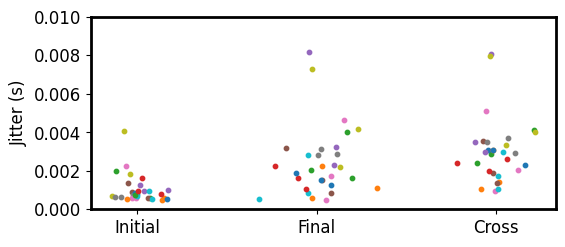

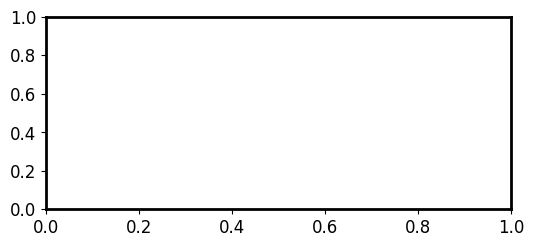

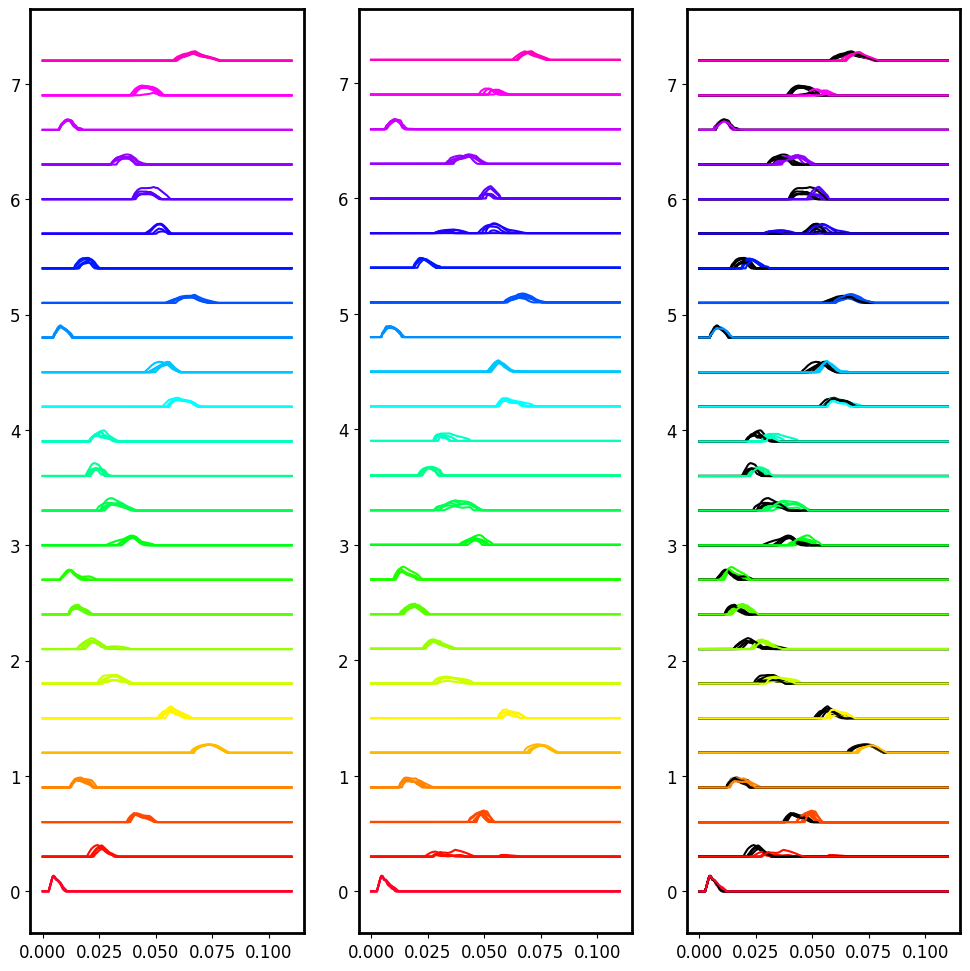

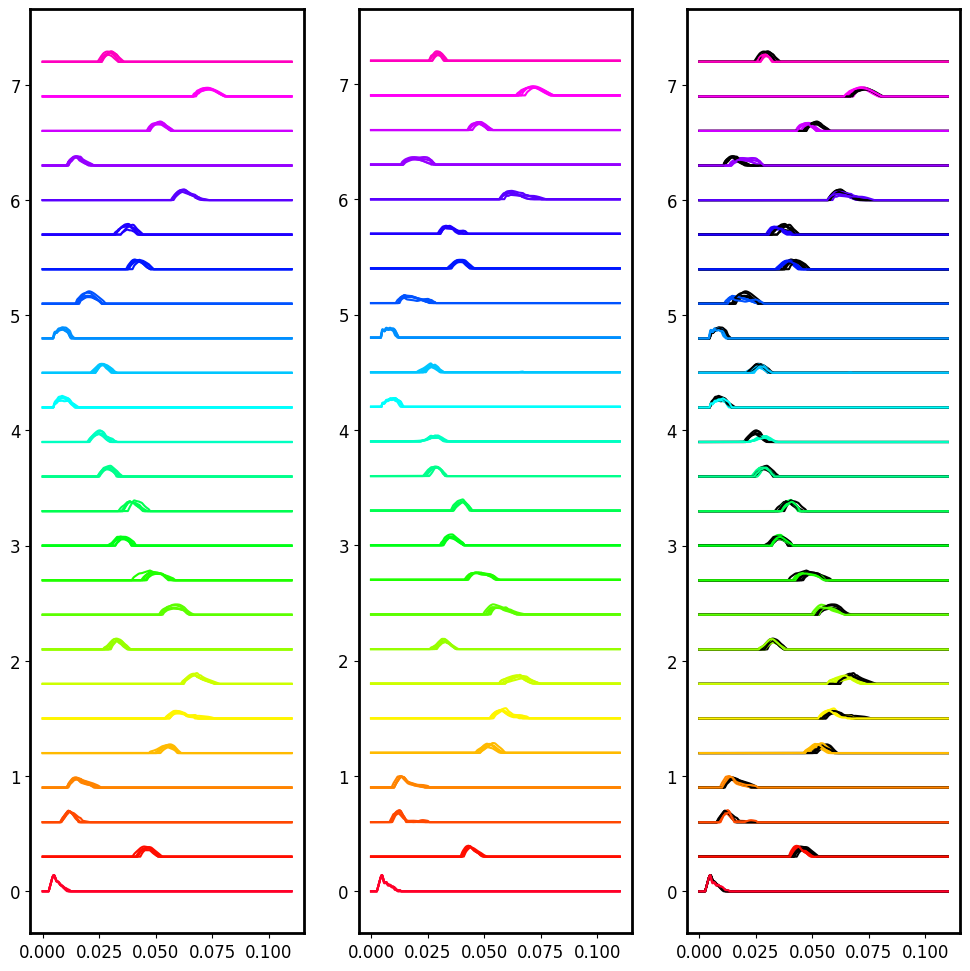

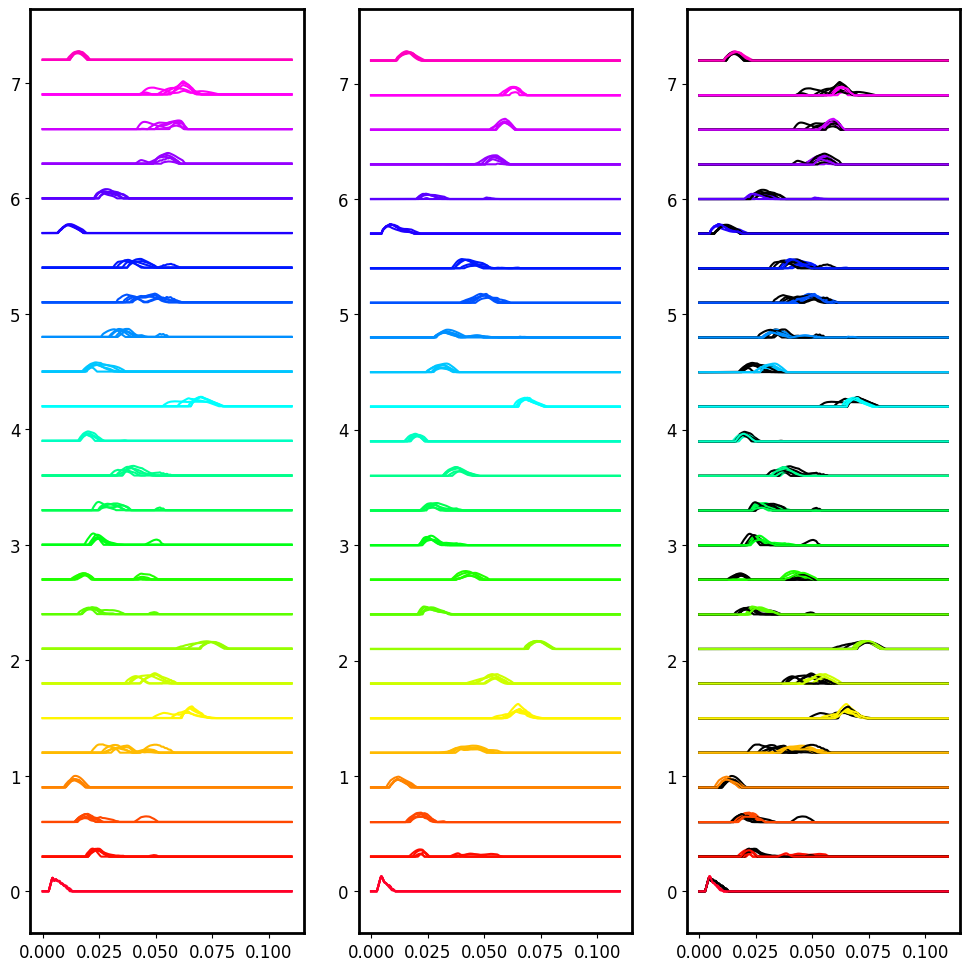

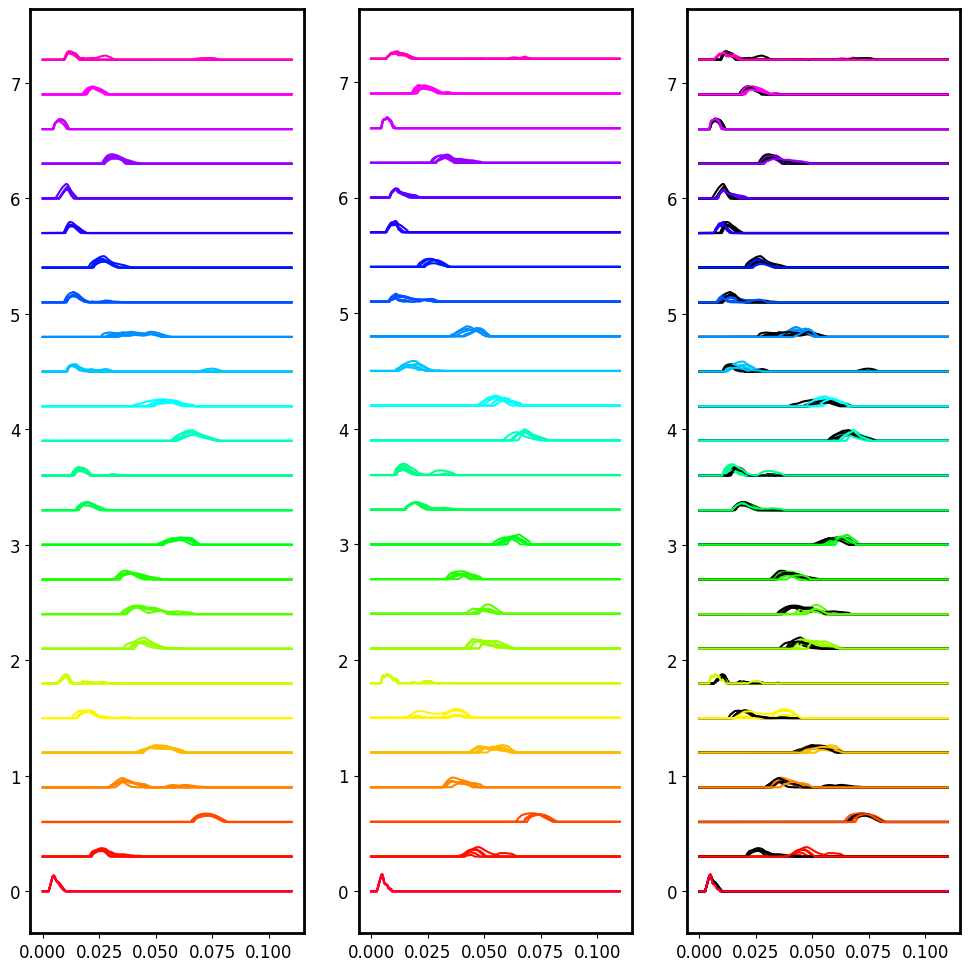

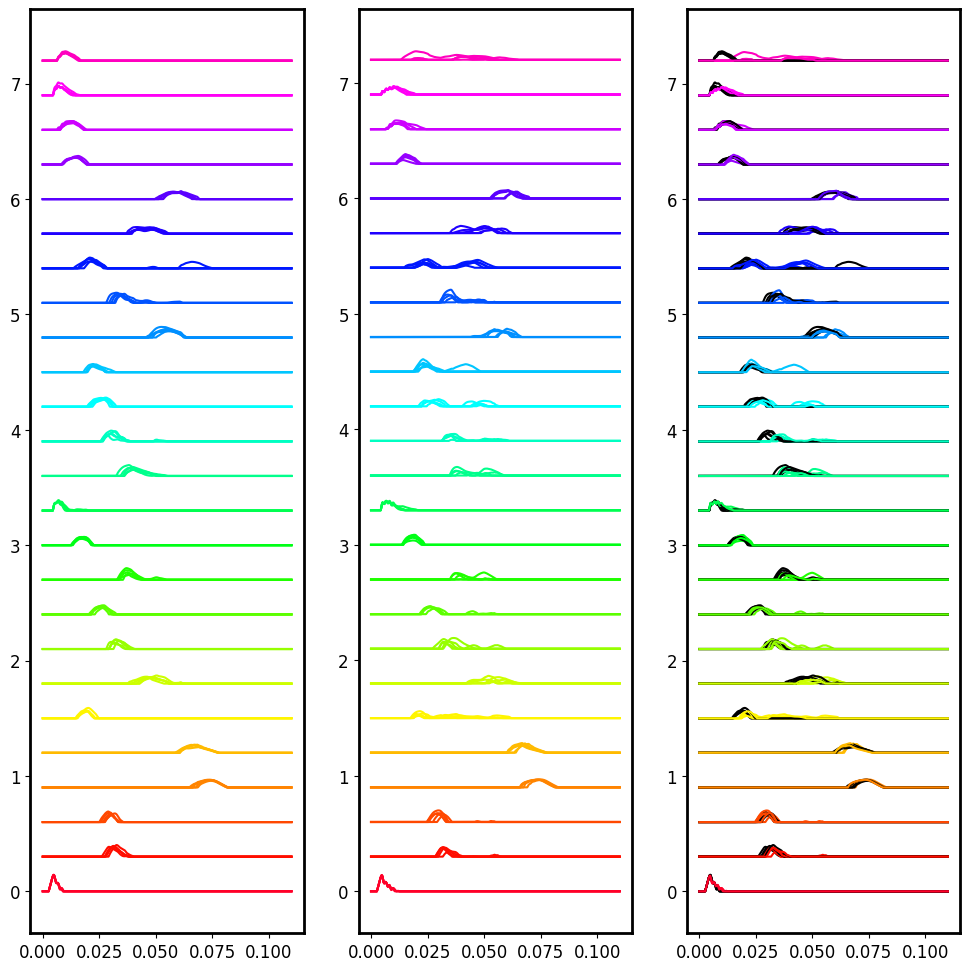

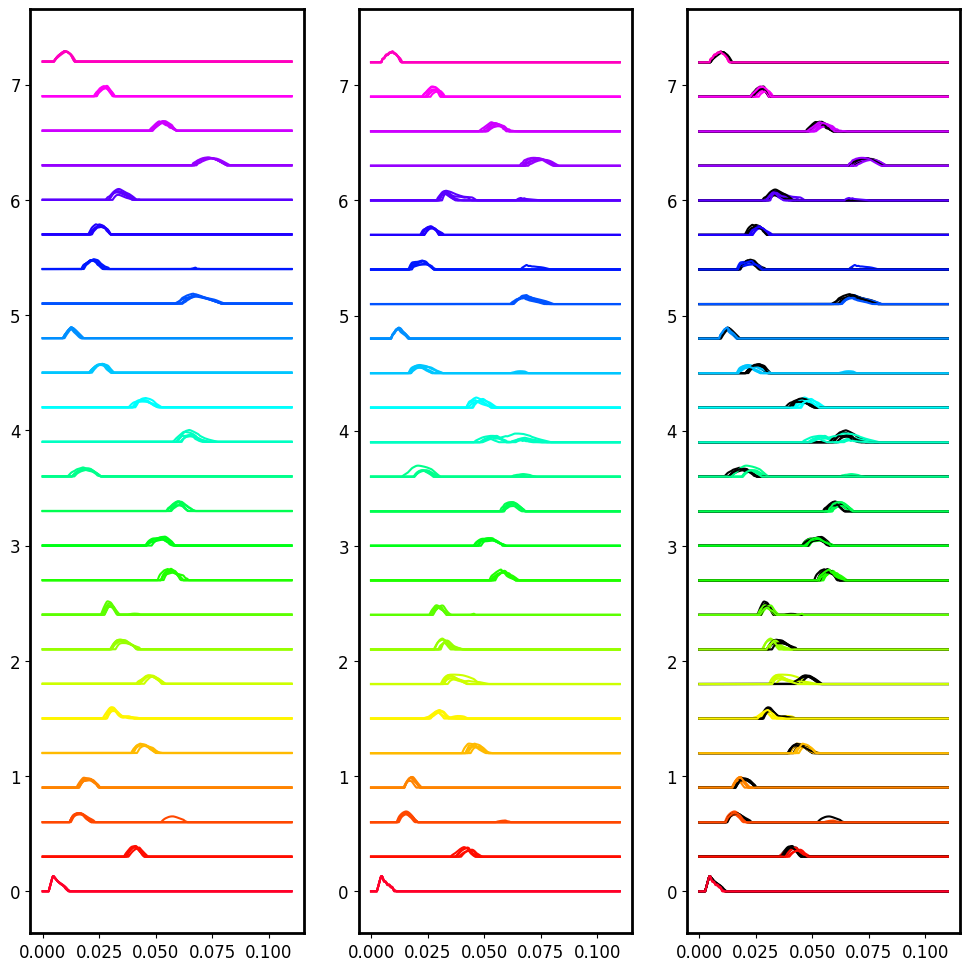

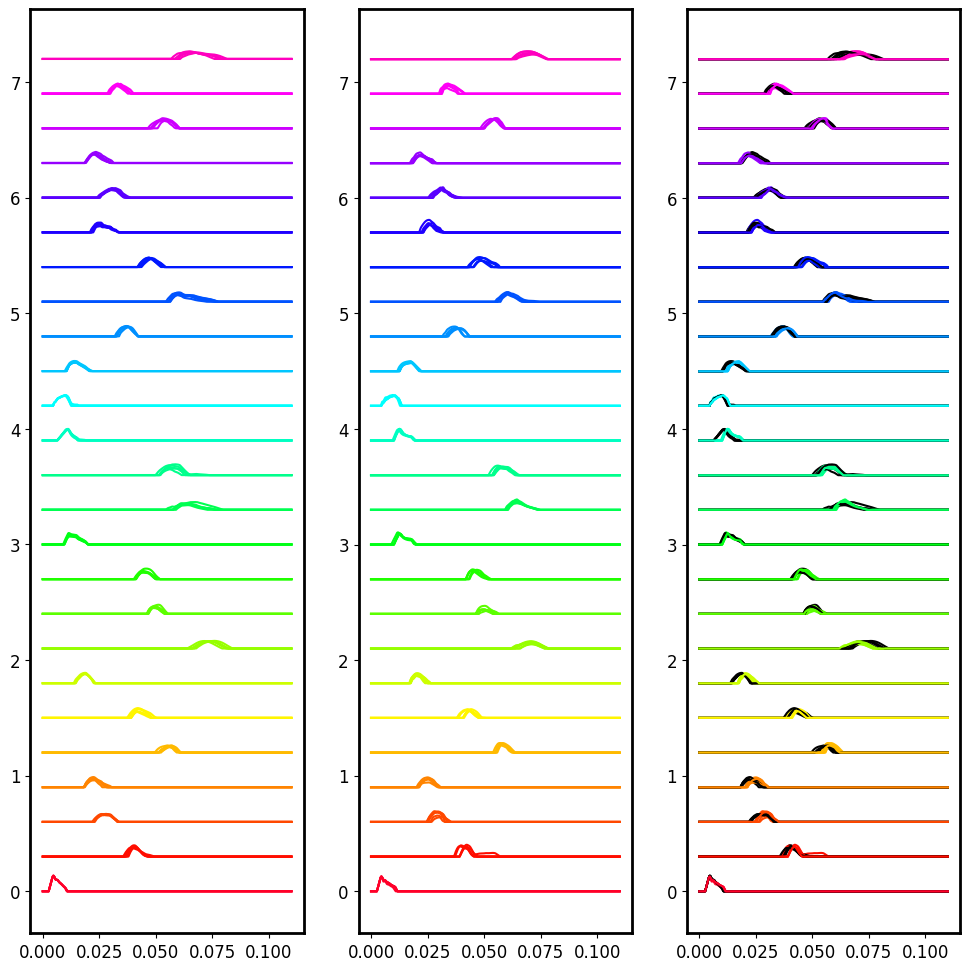

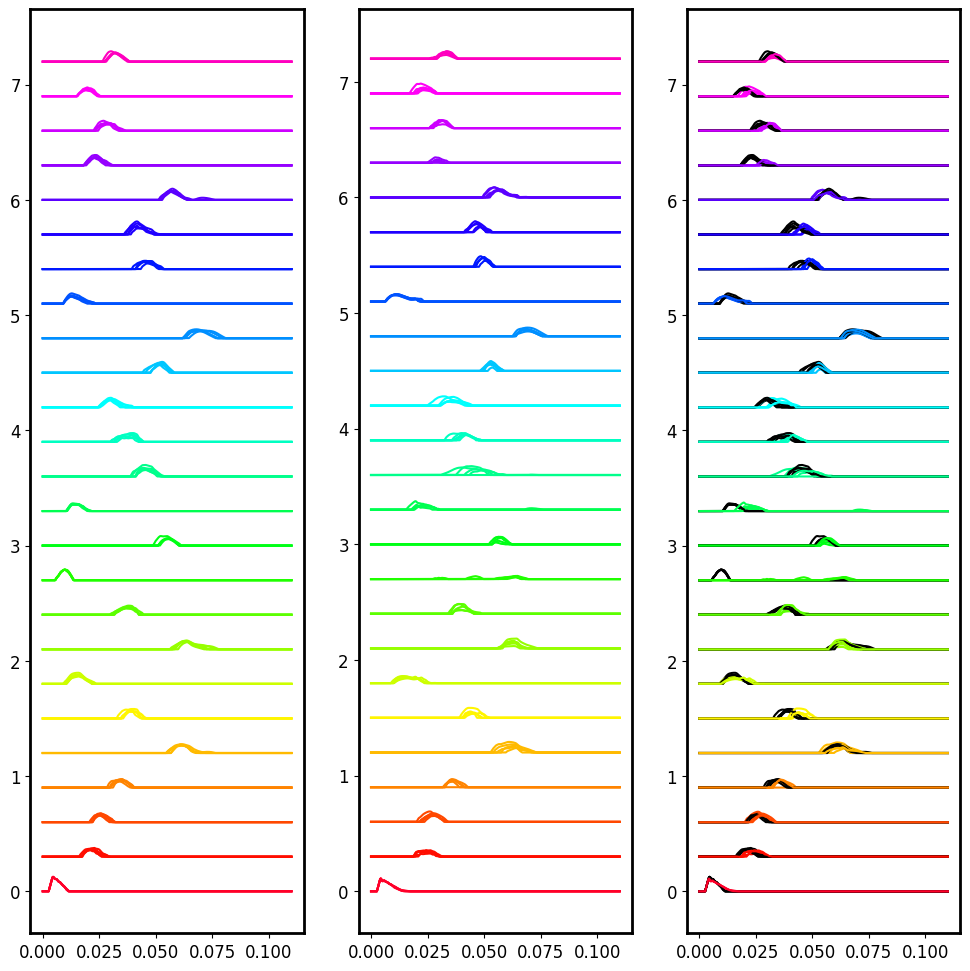

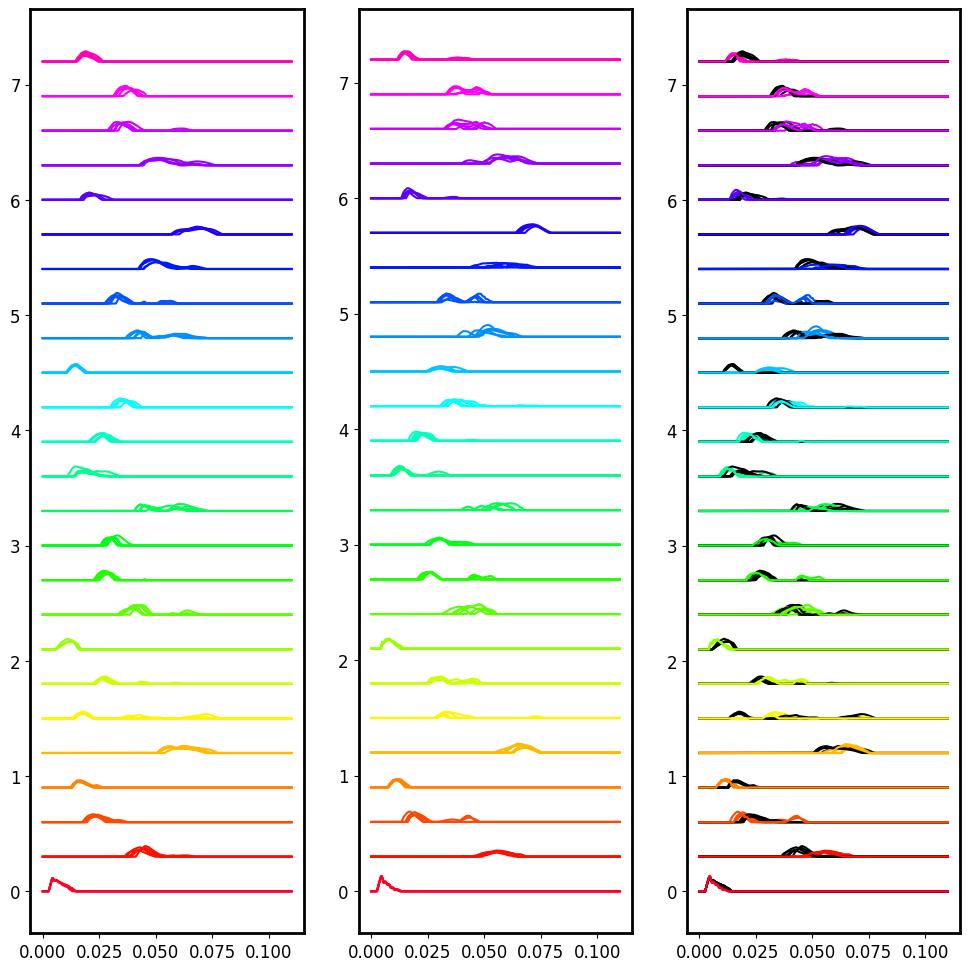

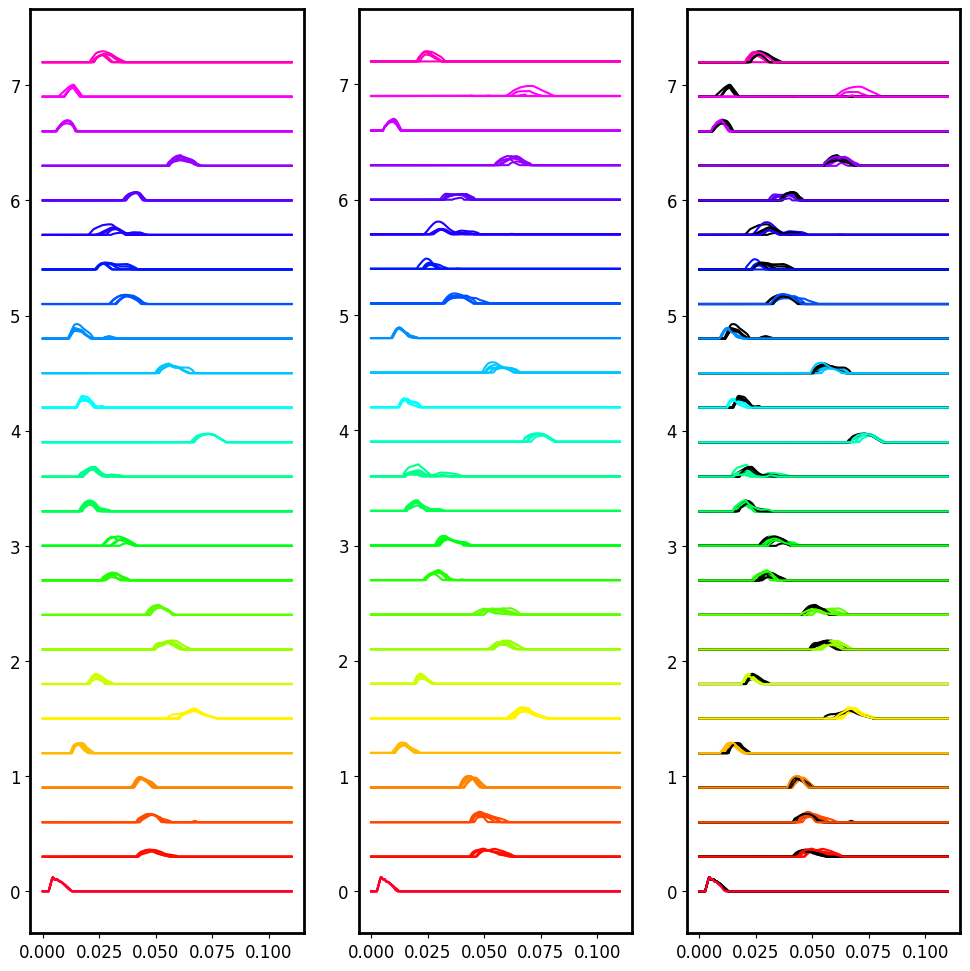

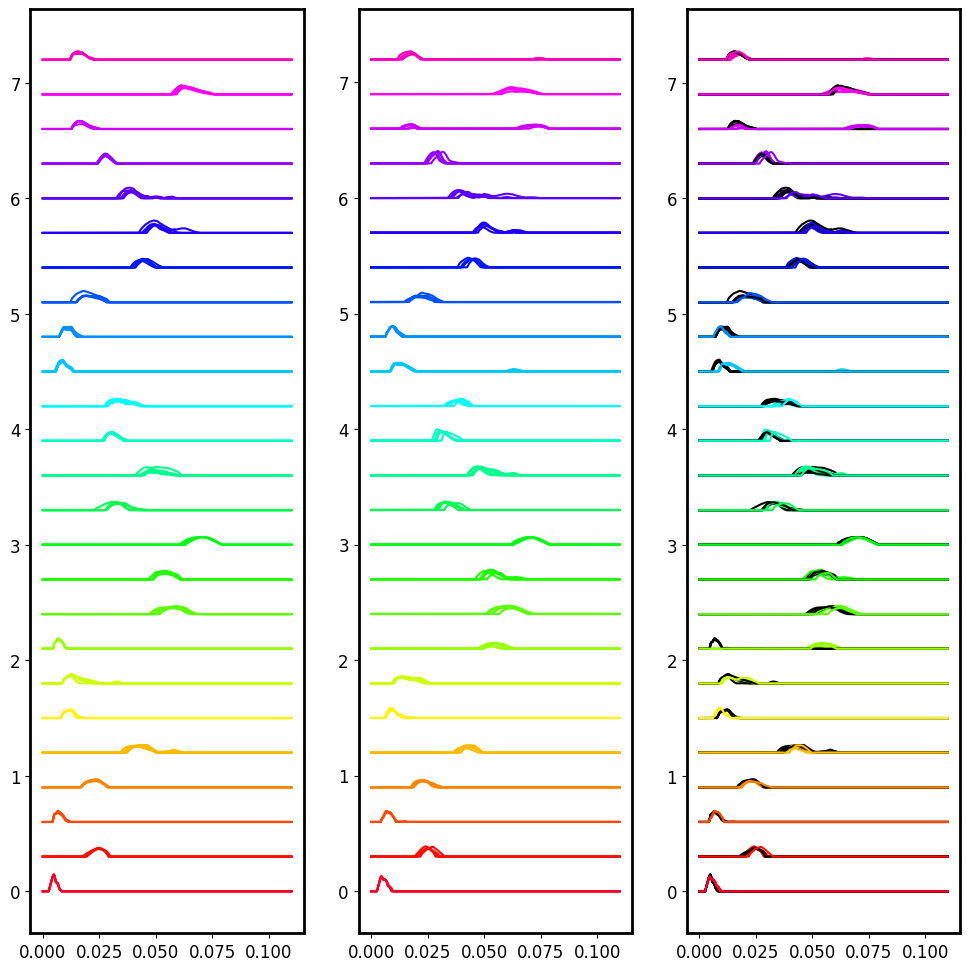

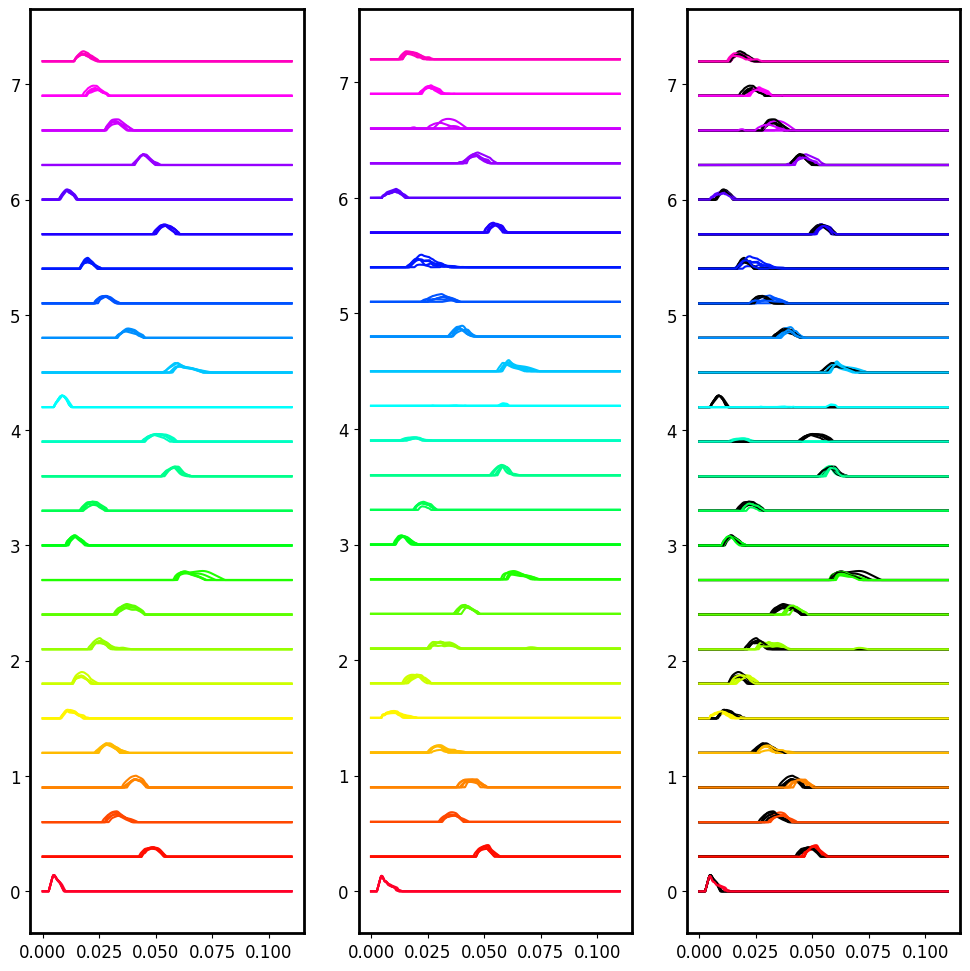

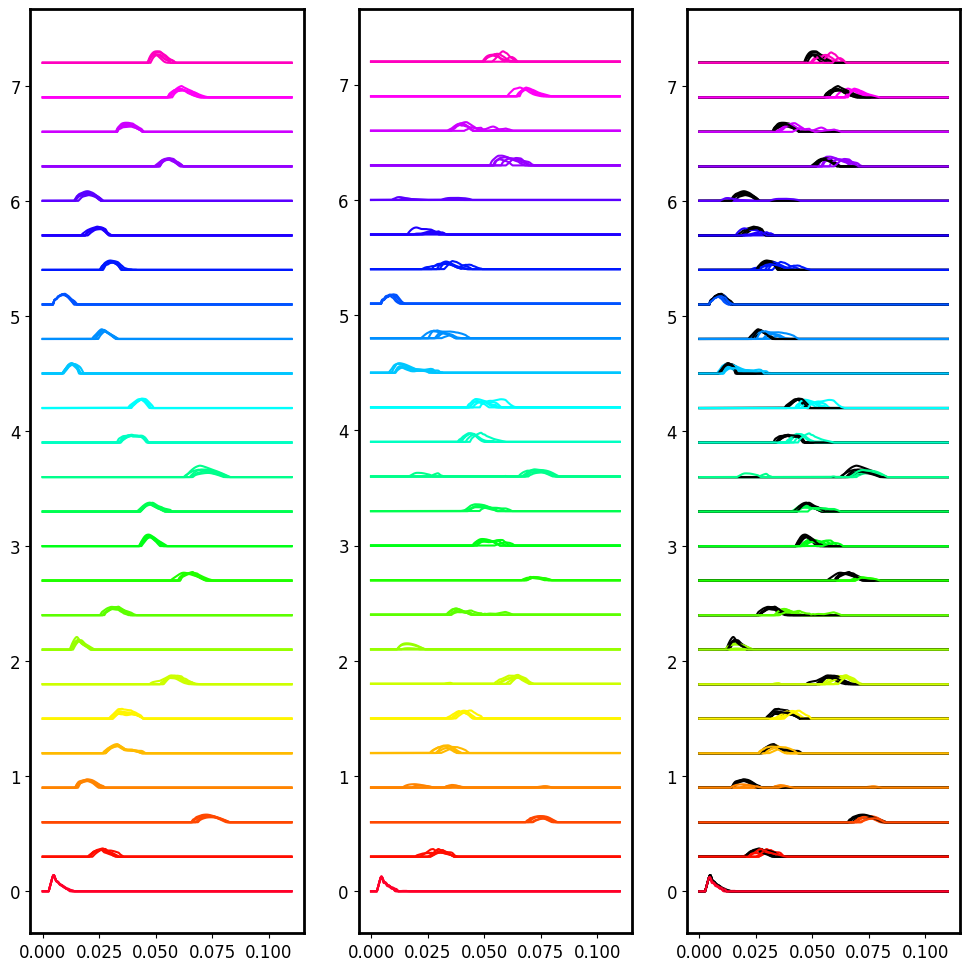

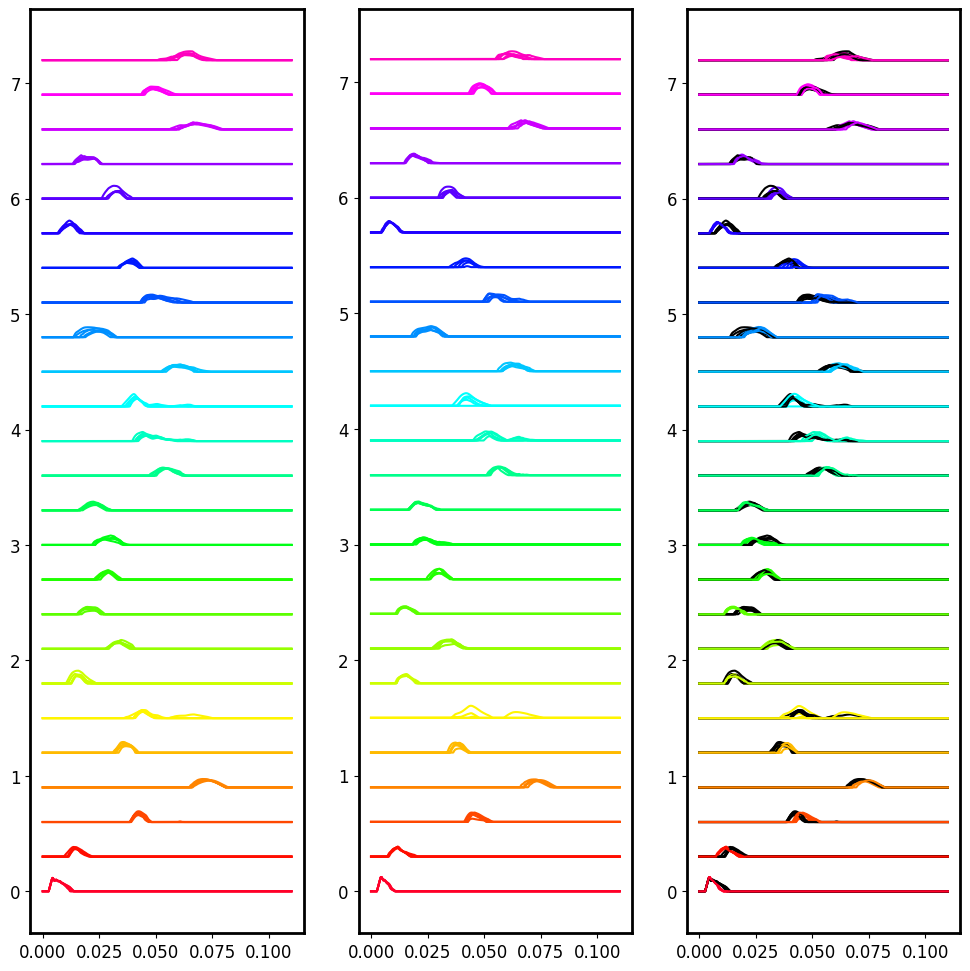

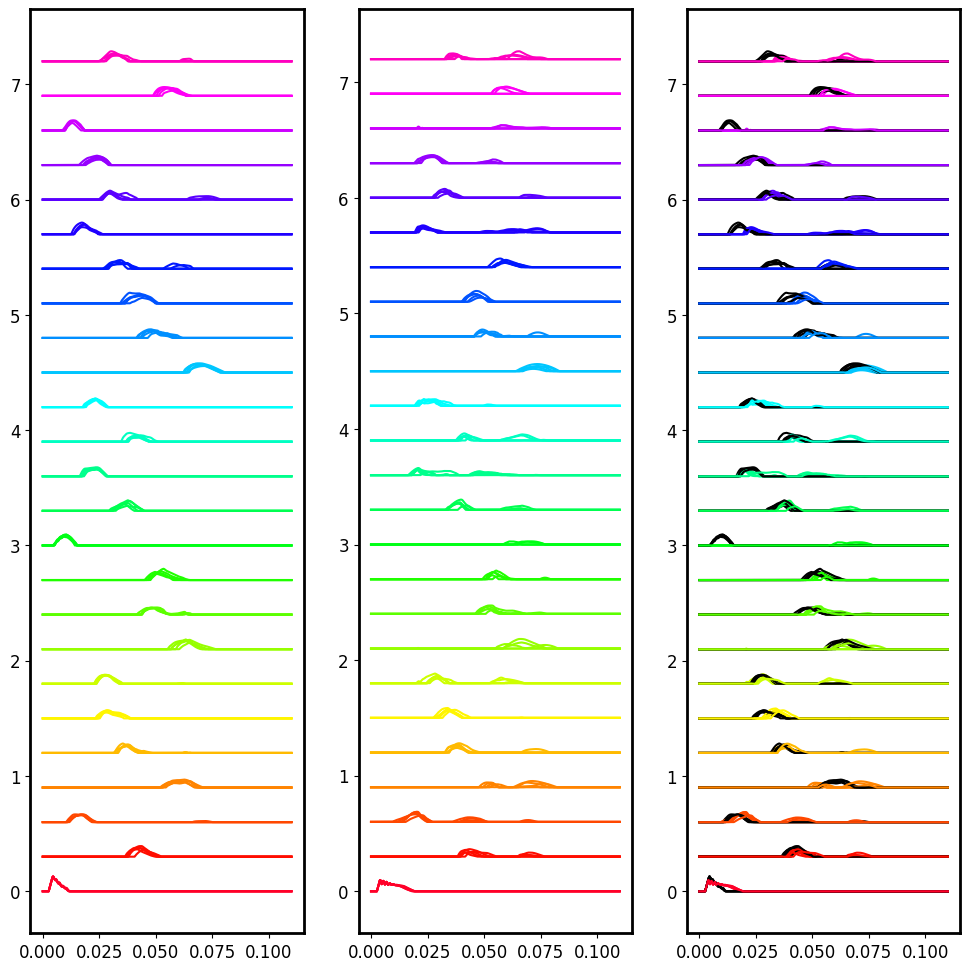

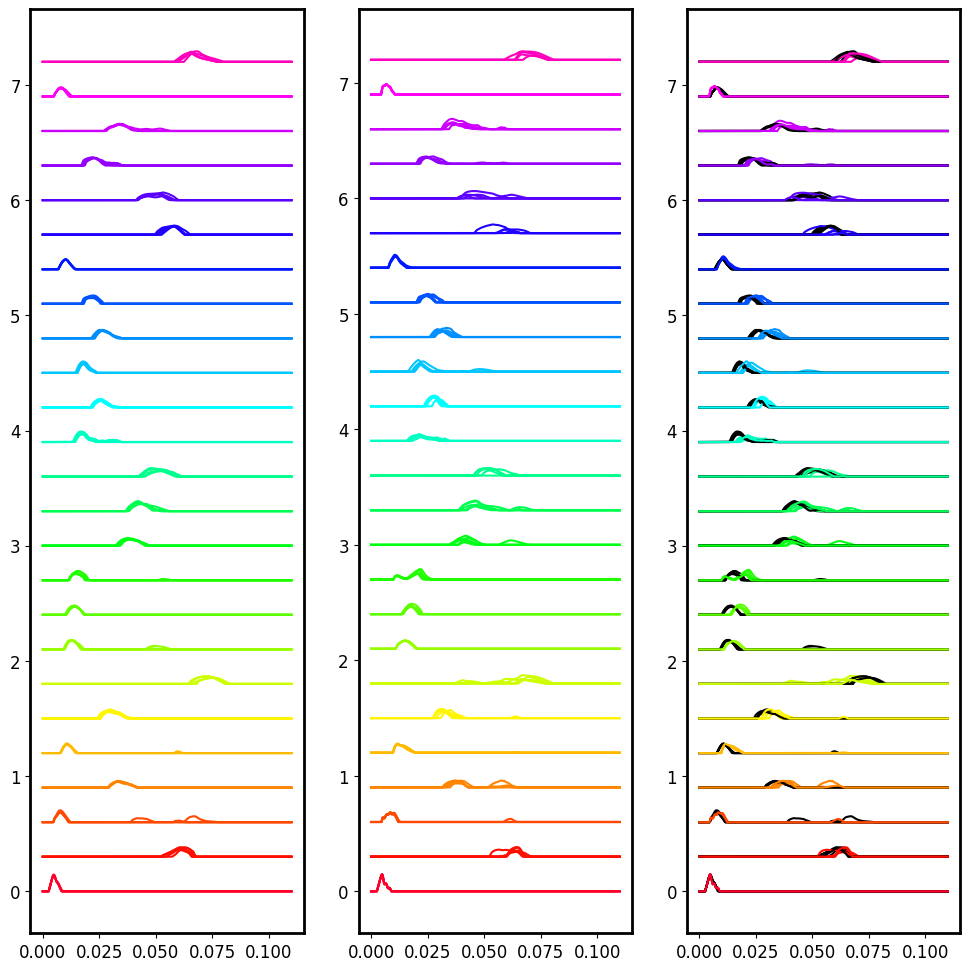

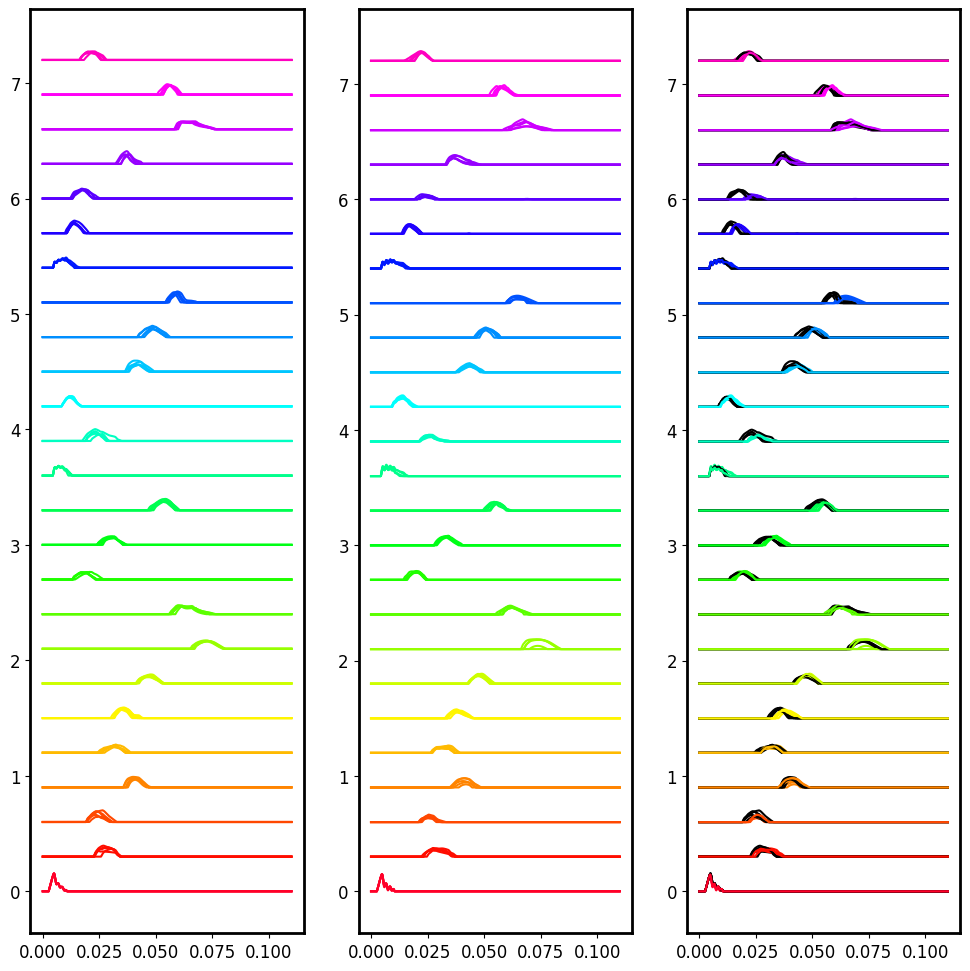

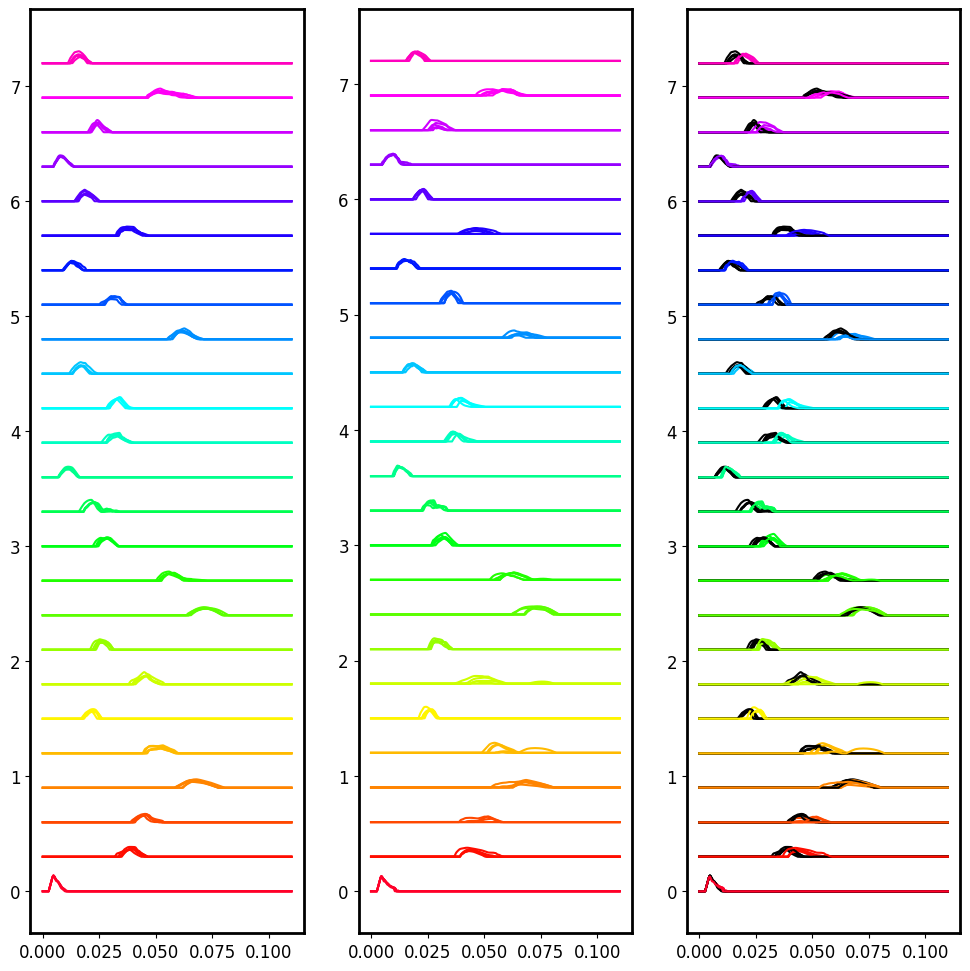

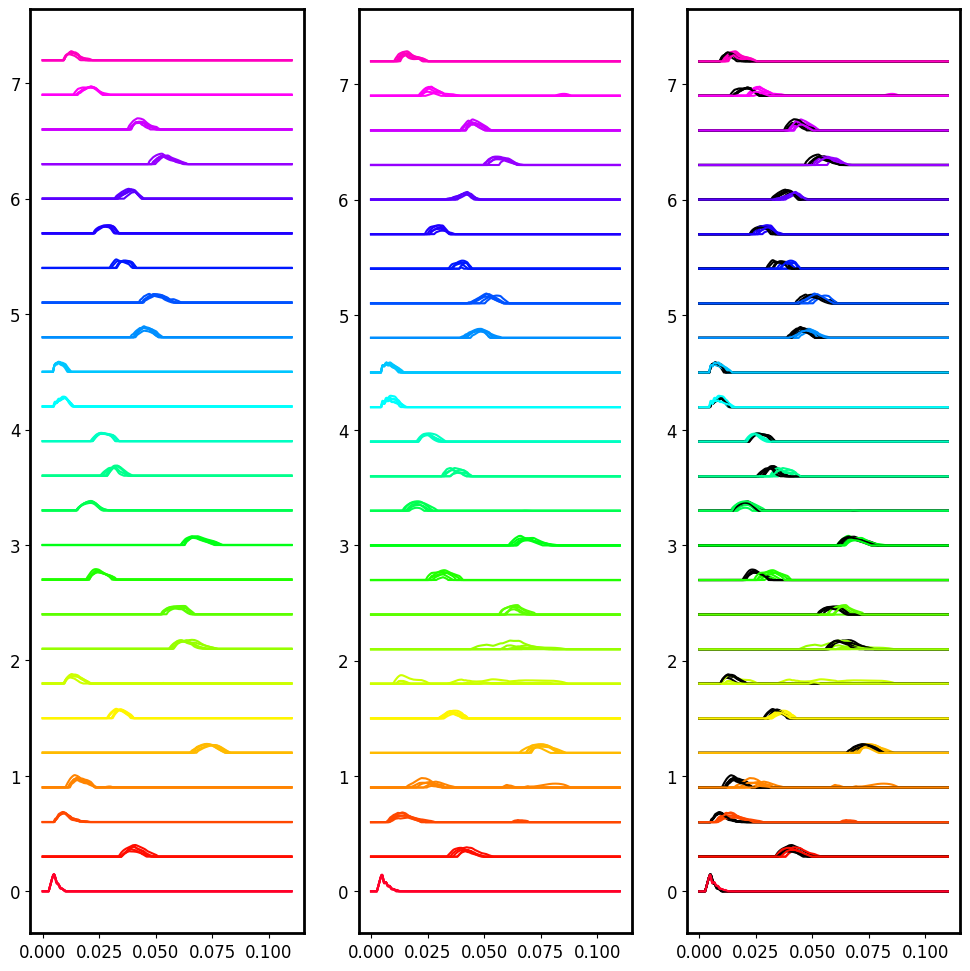

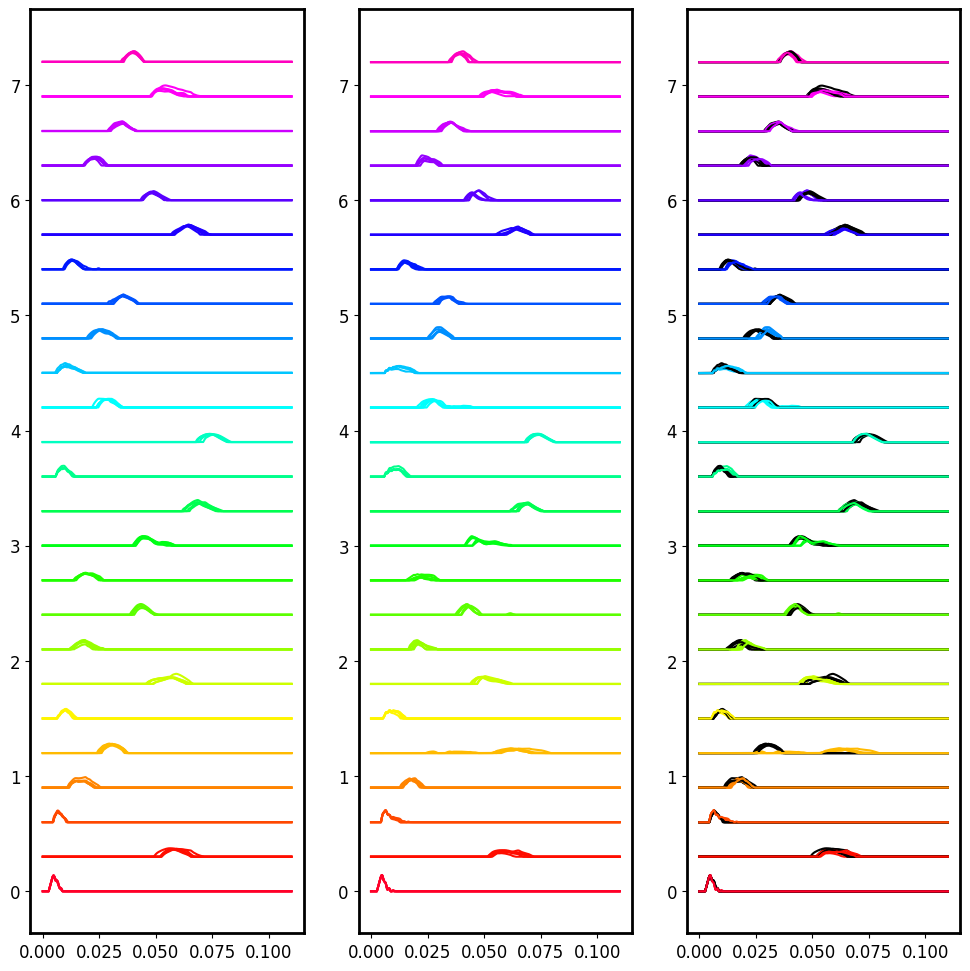

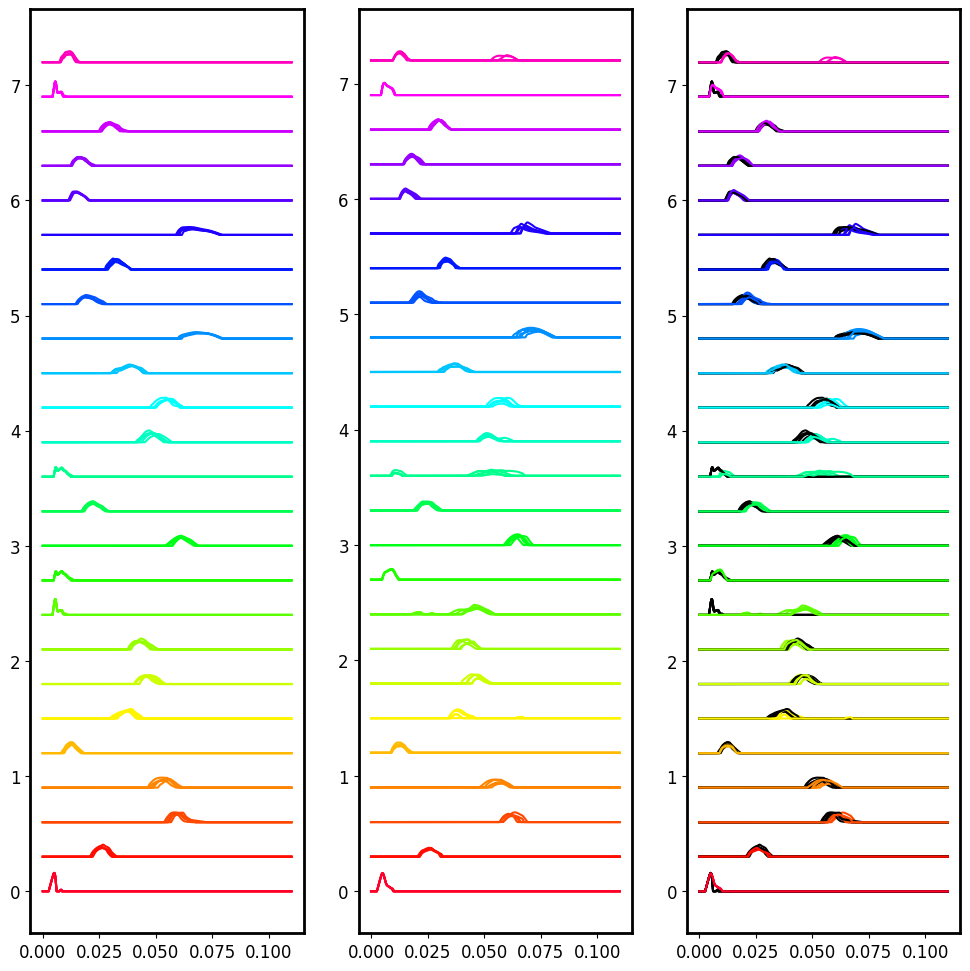

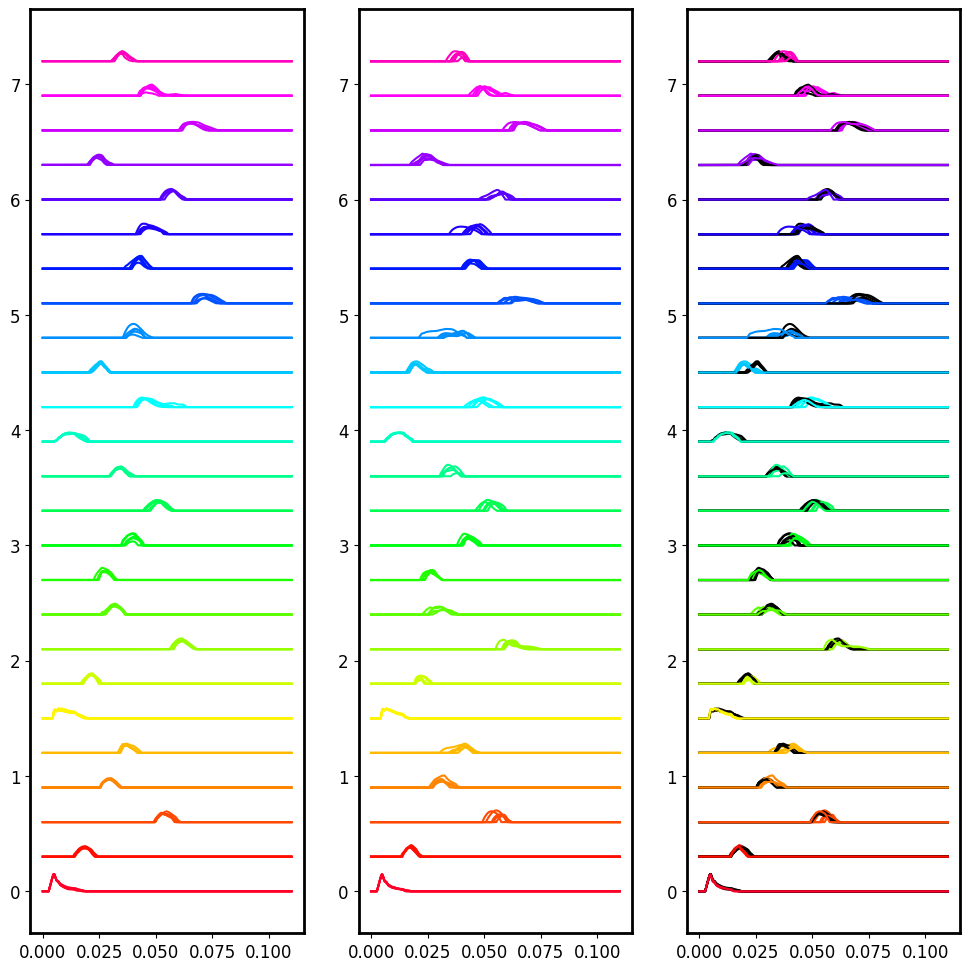

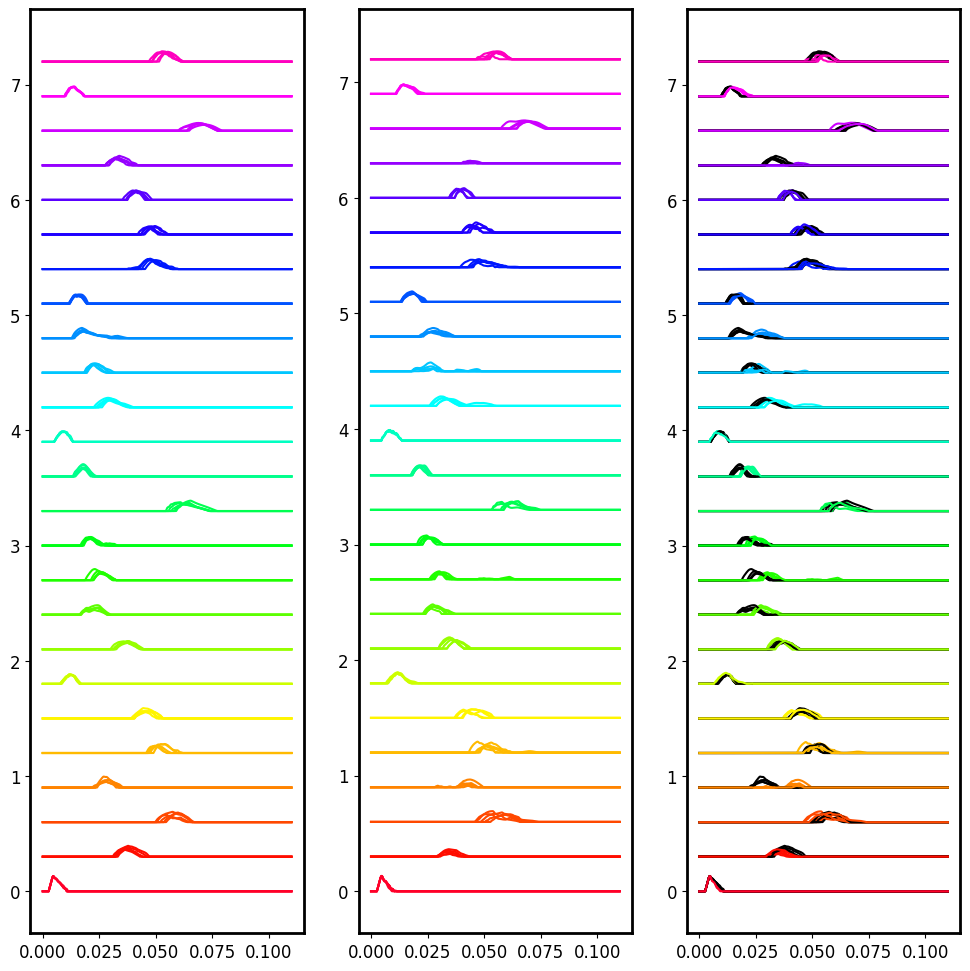

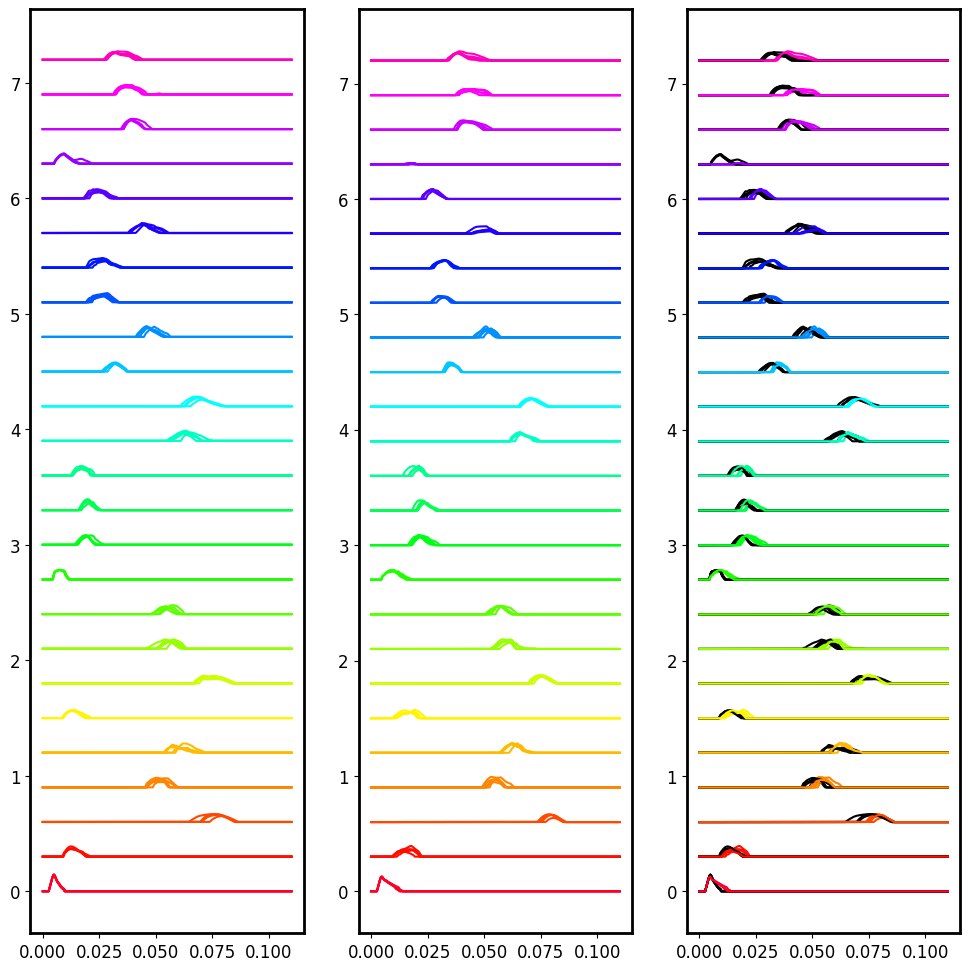

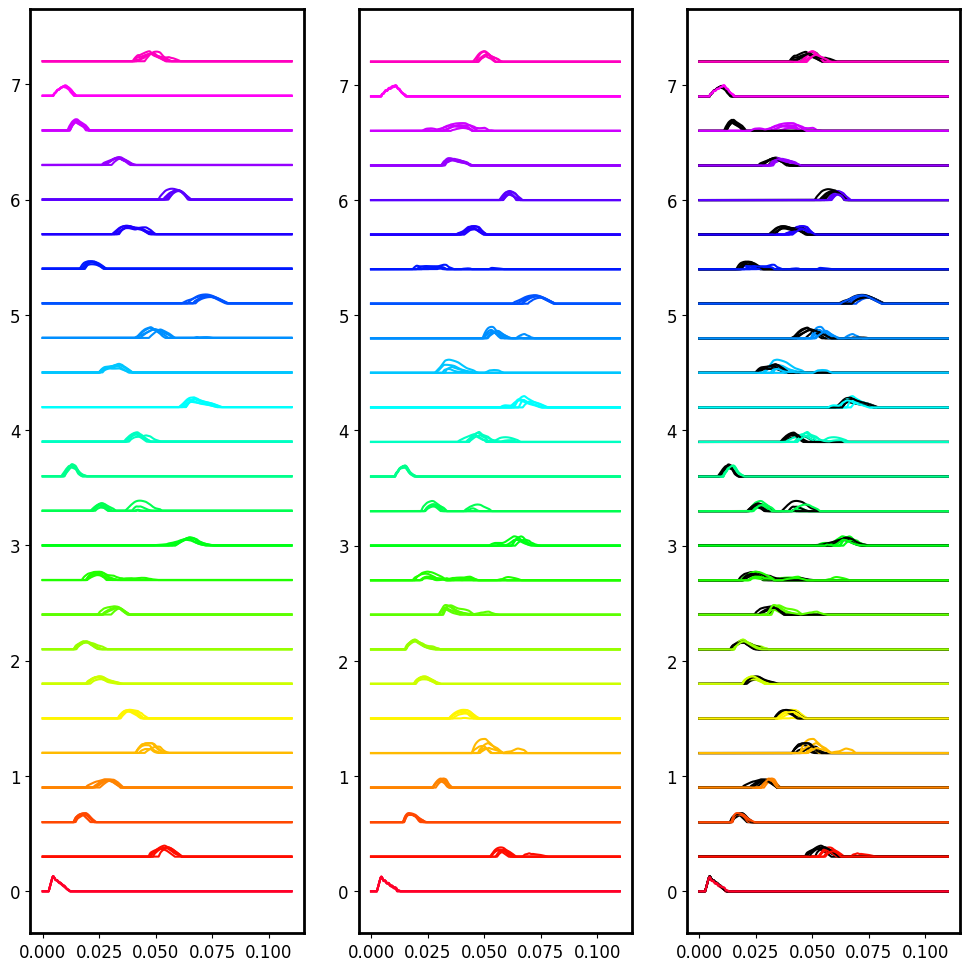

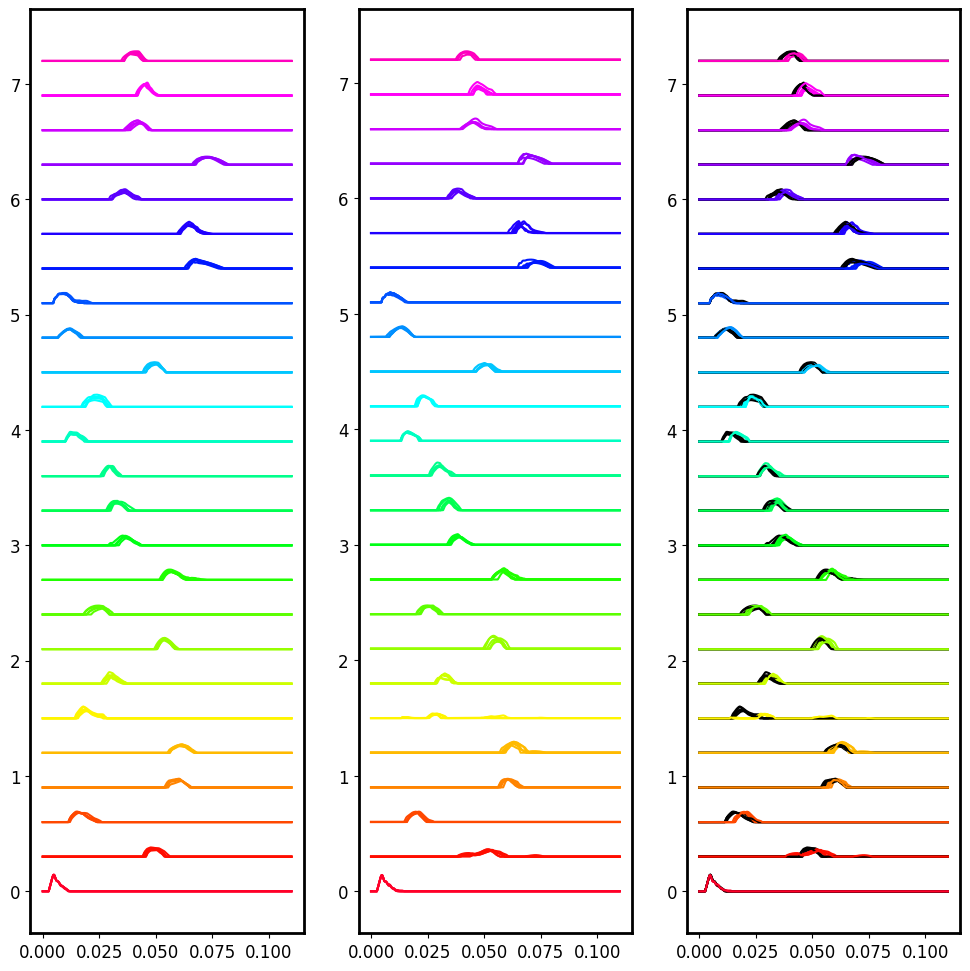

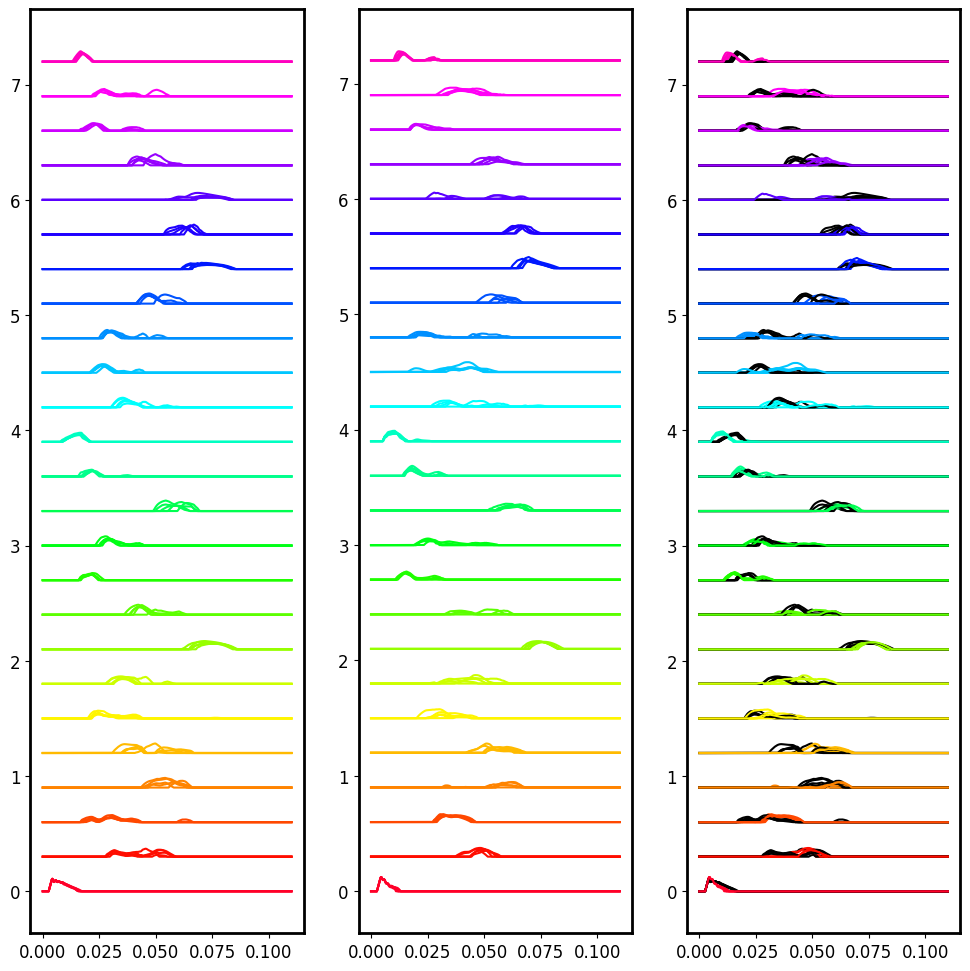

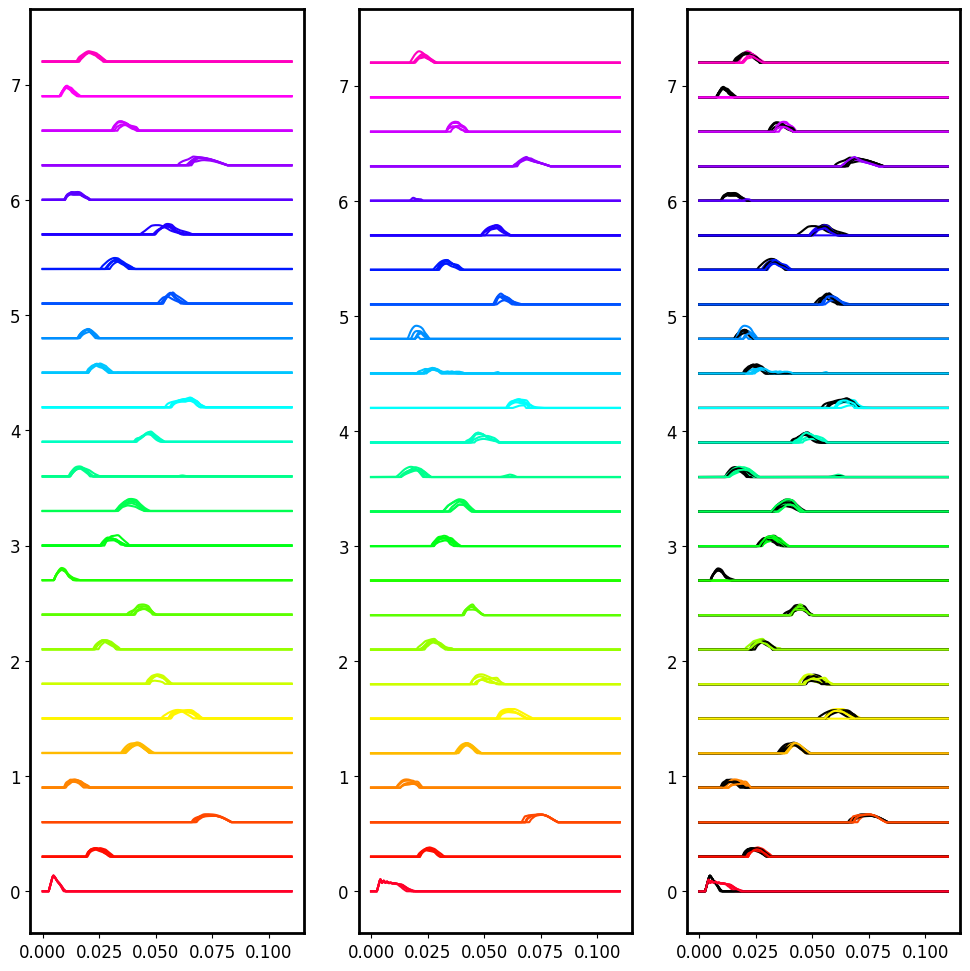

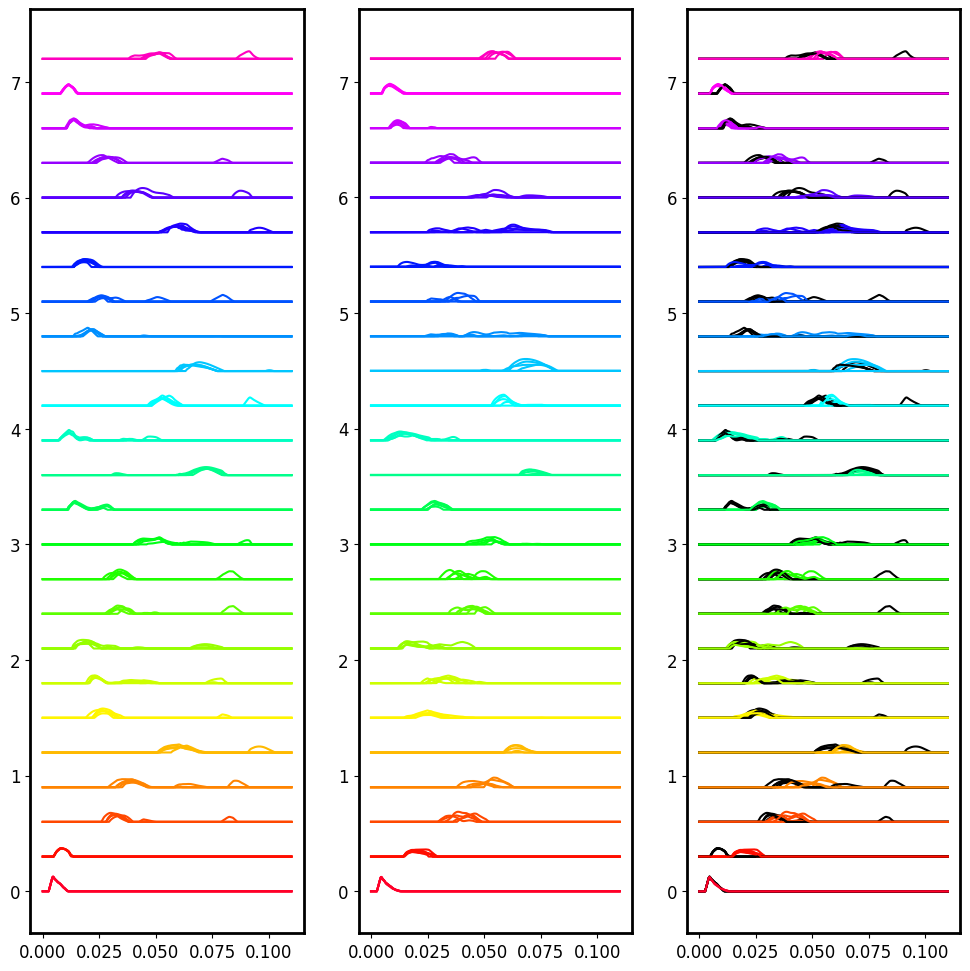

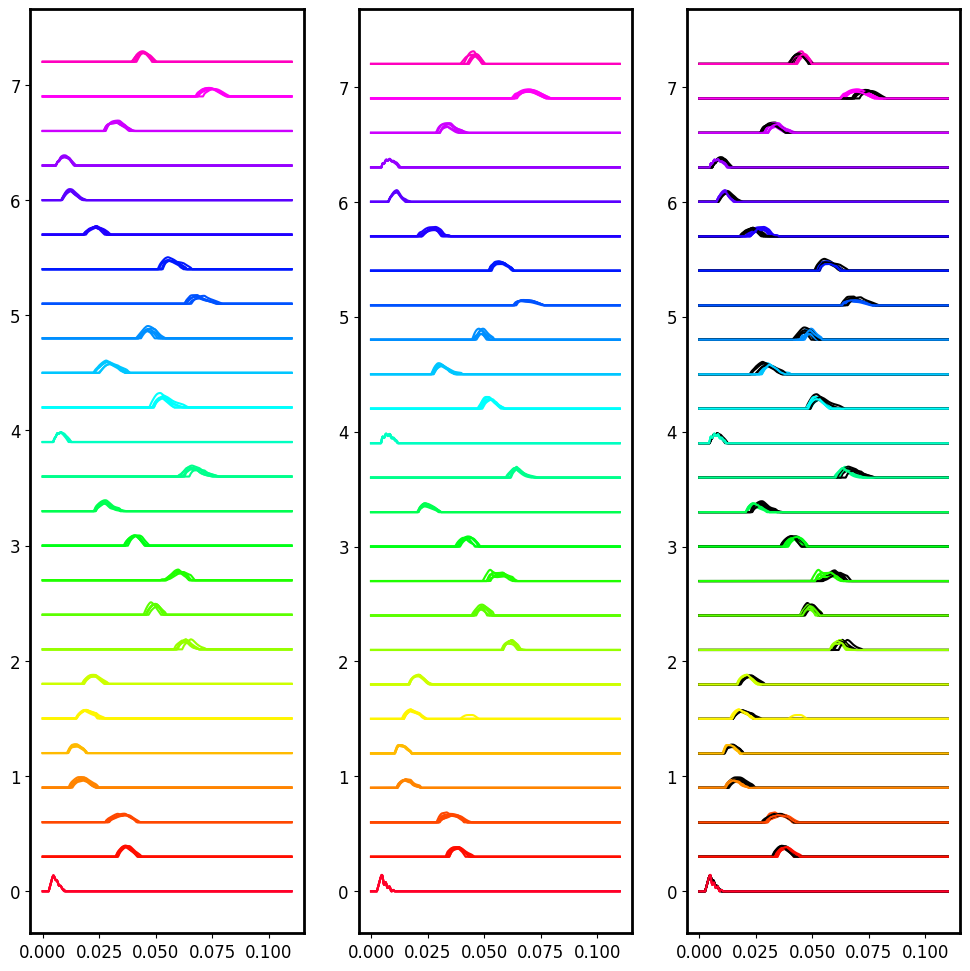

In [26]:
file_name = 'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.002_FRACI_0.75_SEED_51_2024-01-18_12:27:44.746795'
plot_activity([file_name], repeats=30)

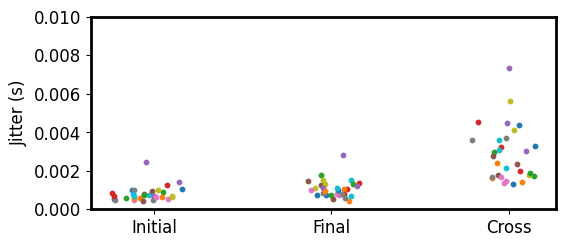

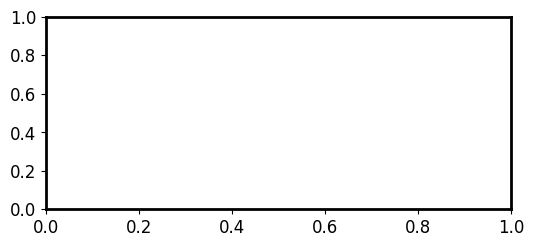

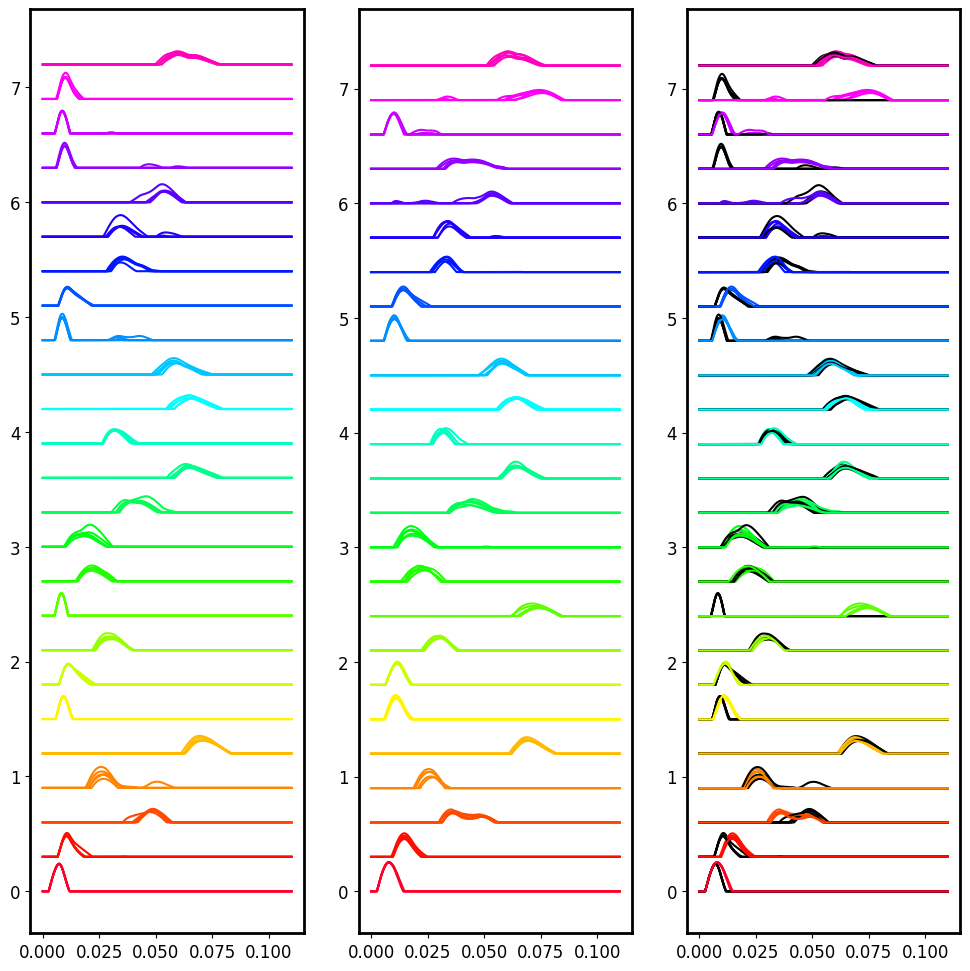

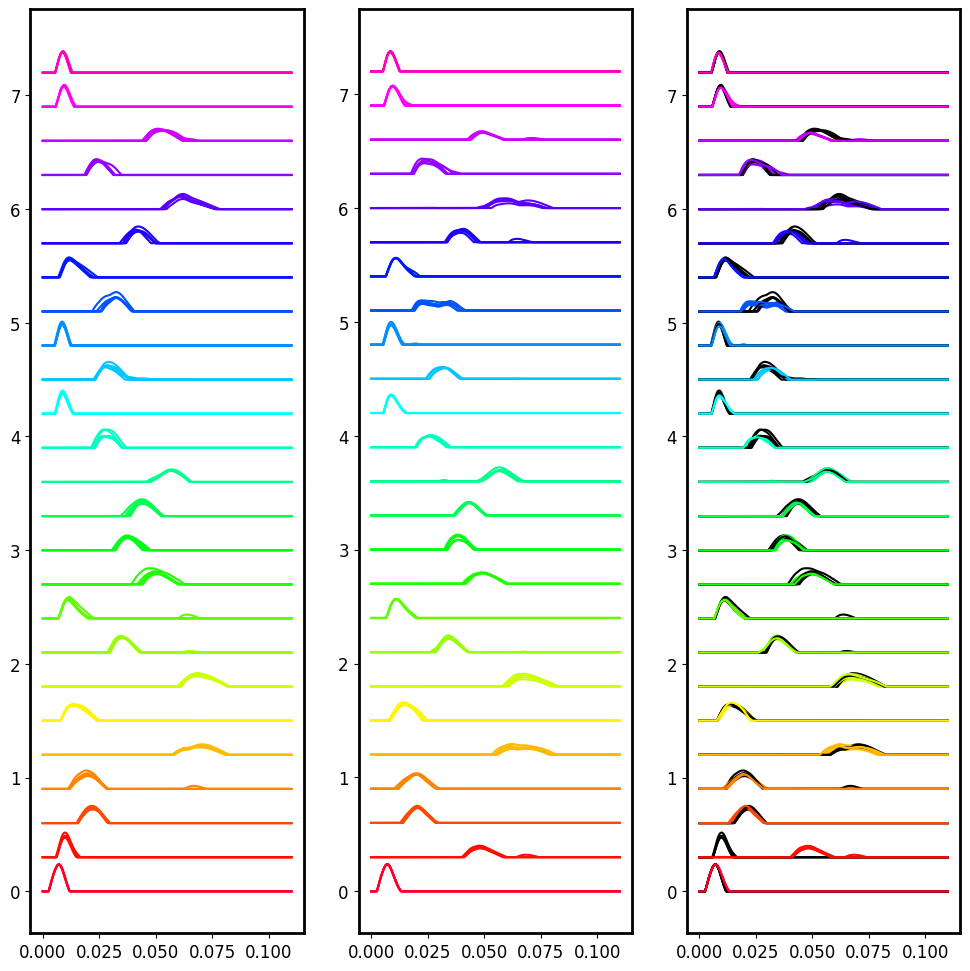

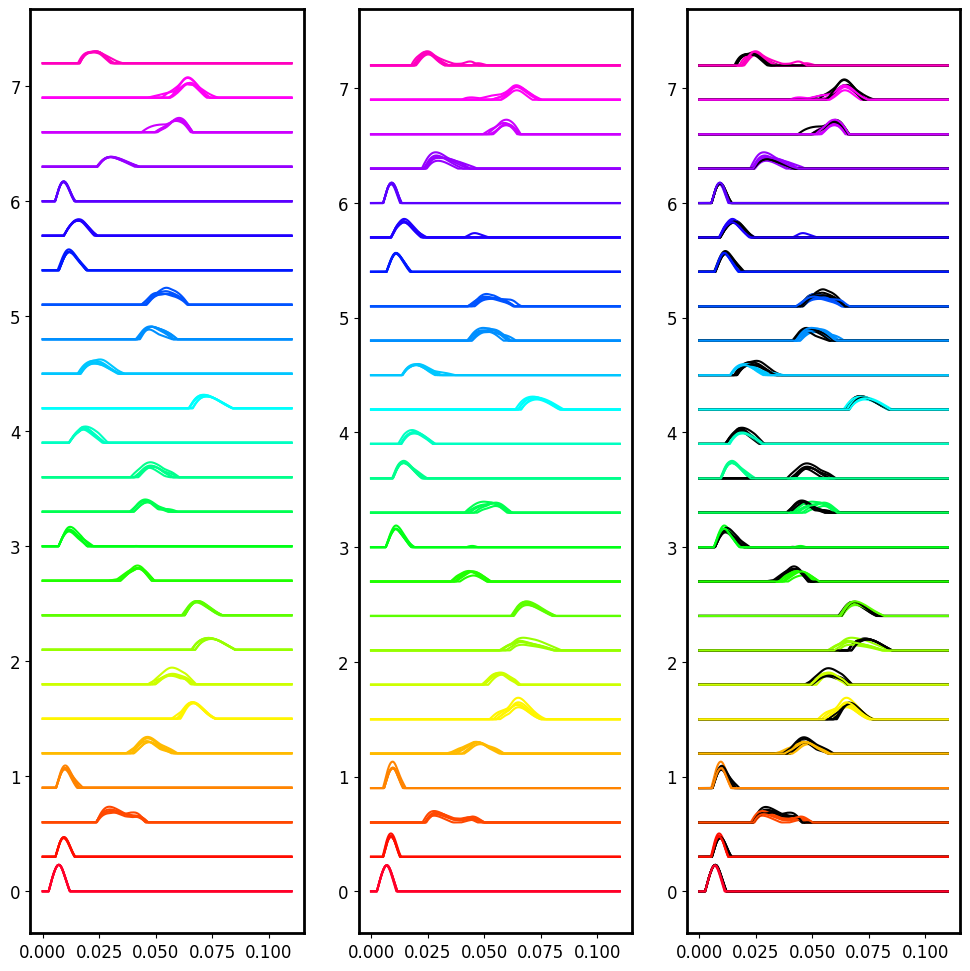

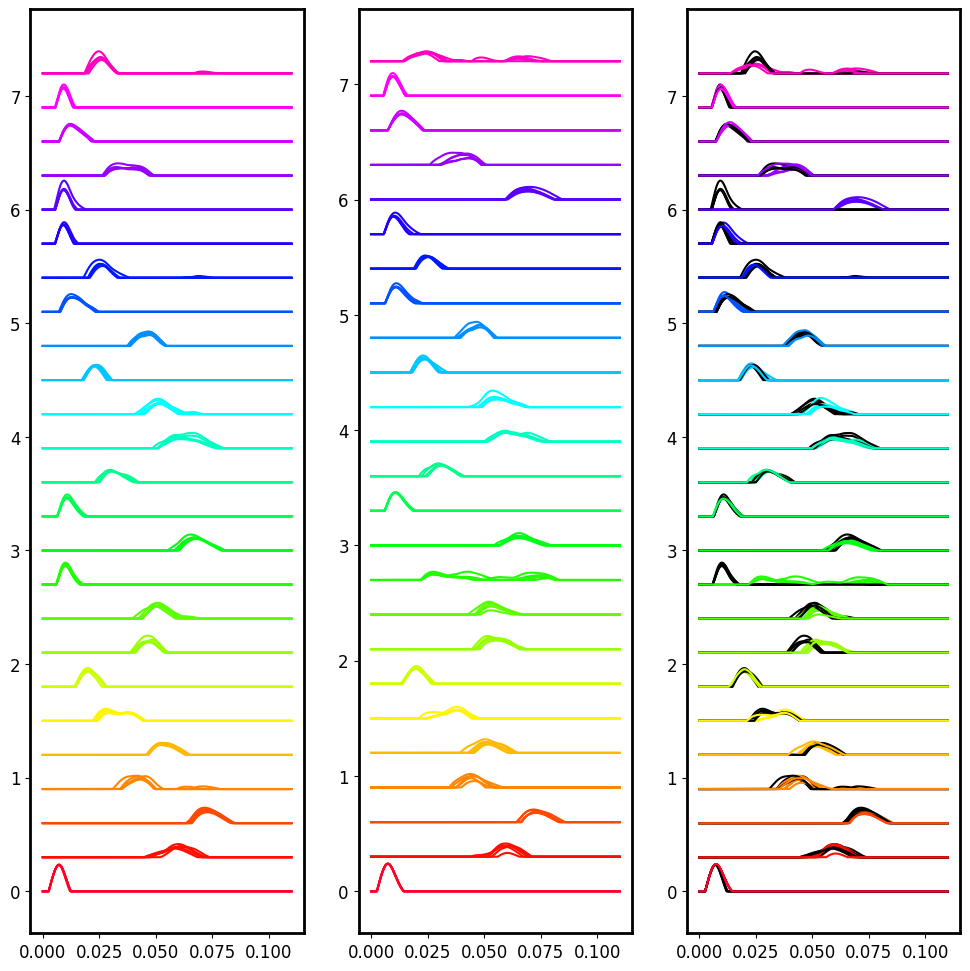

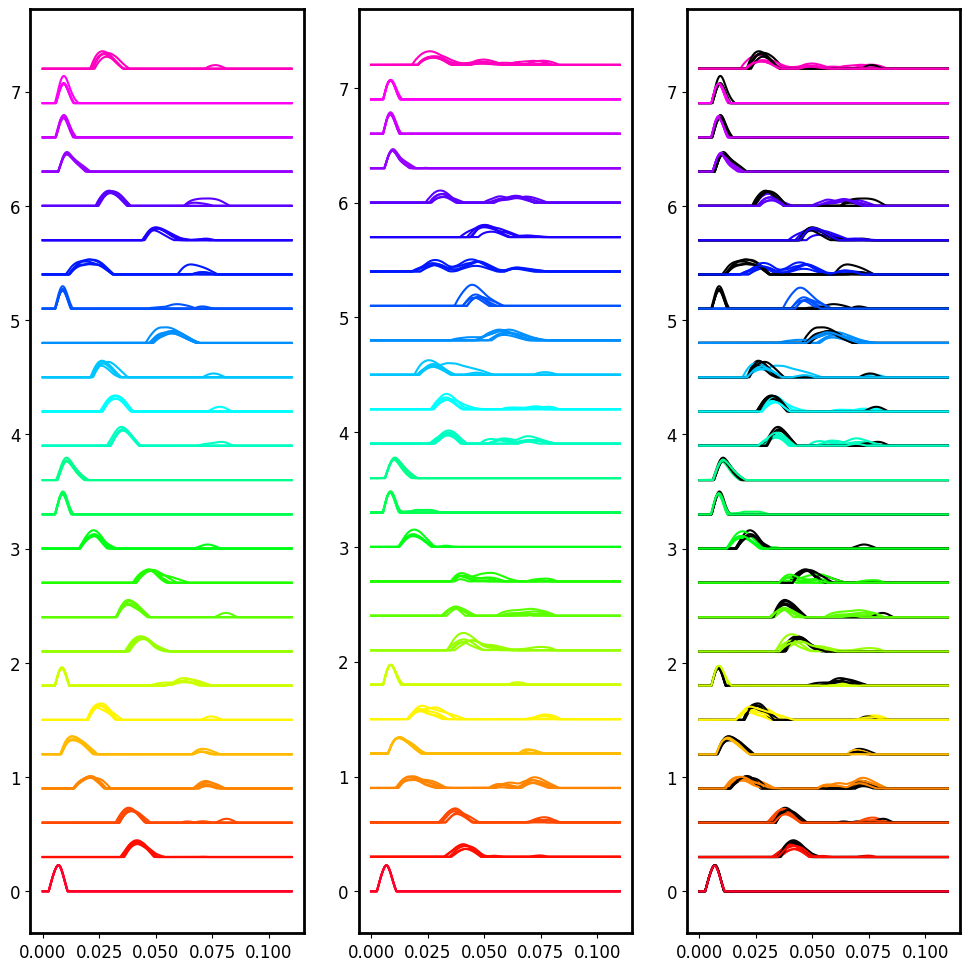

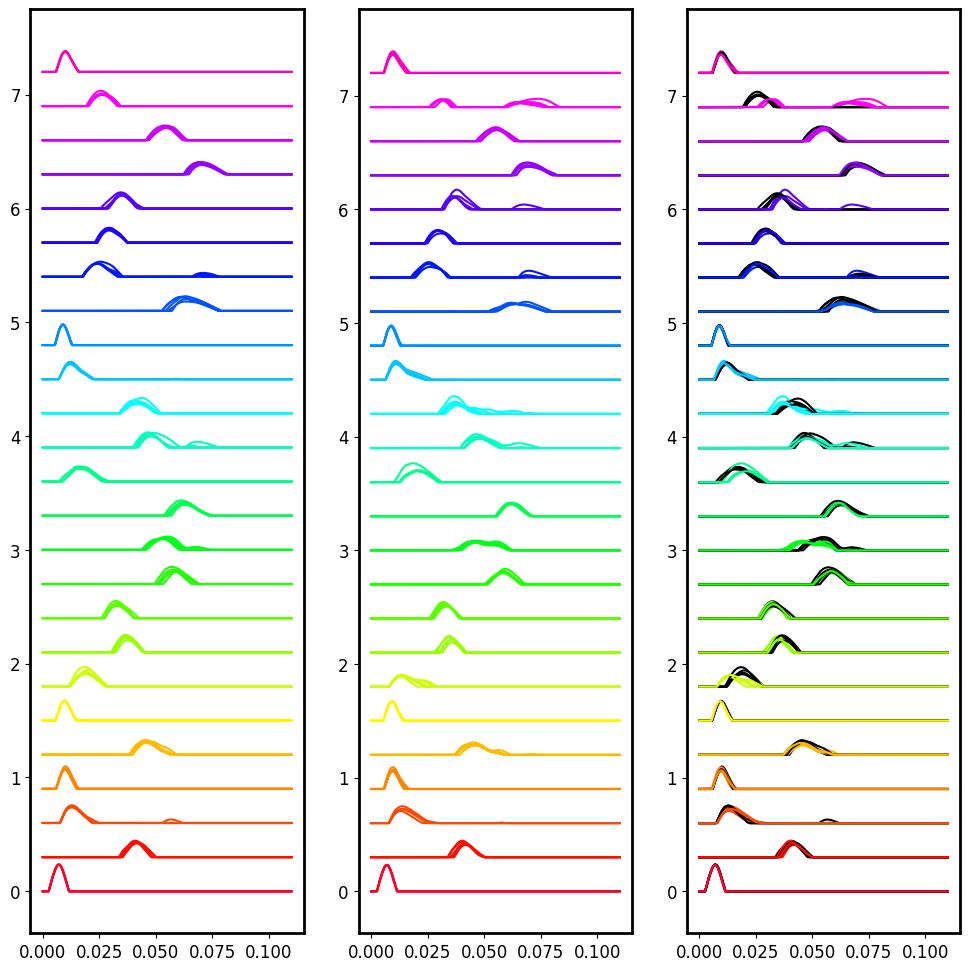

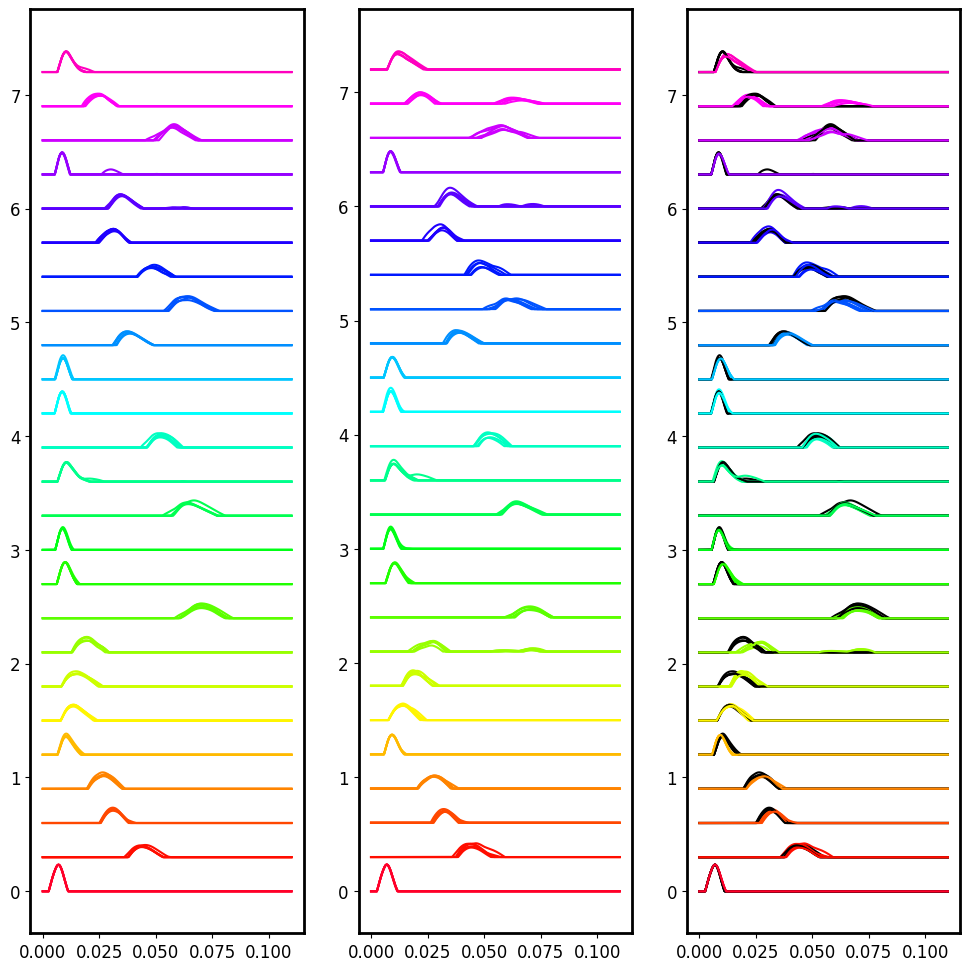

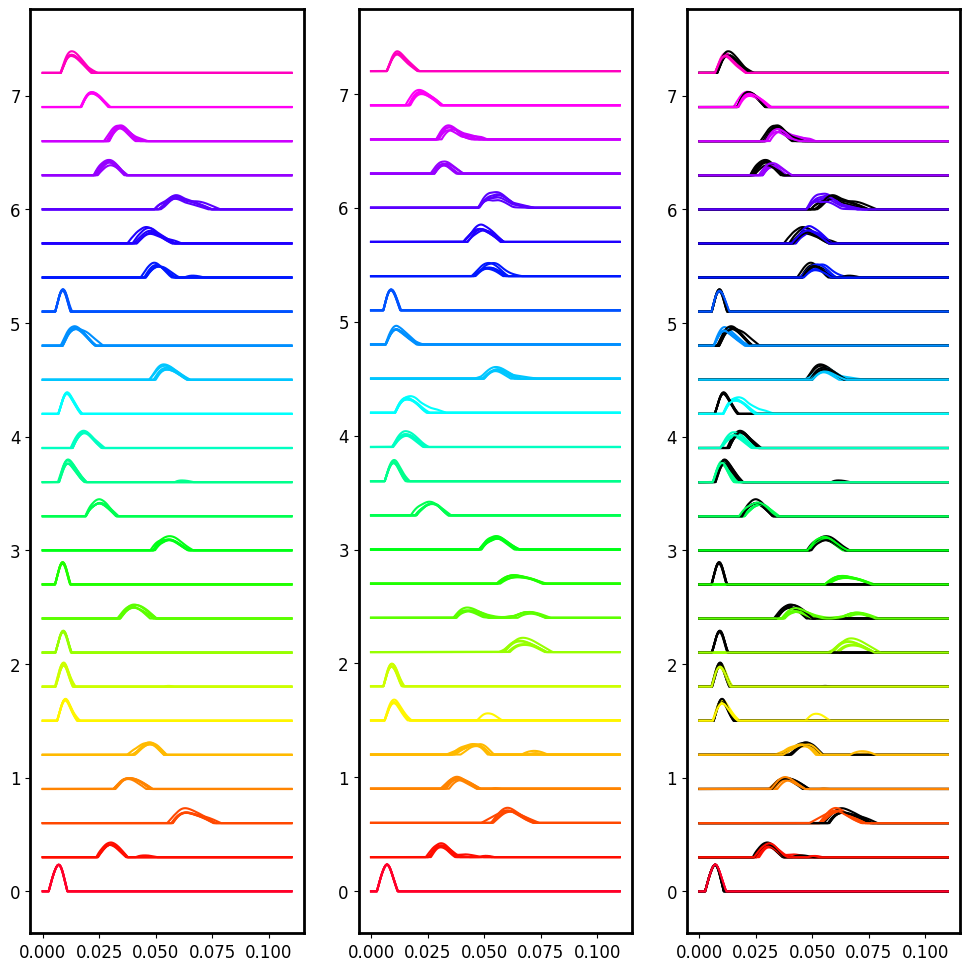

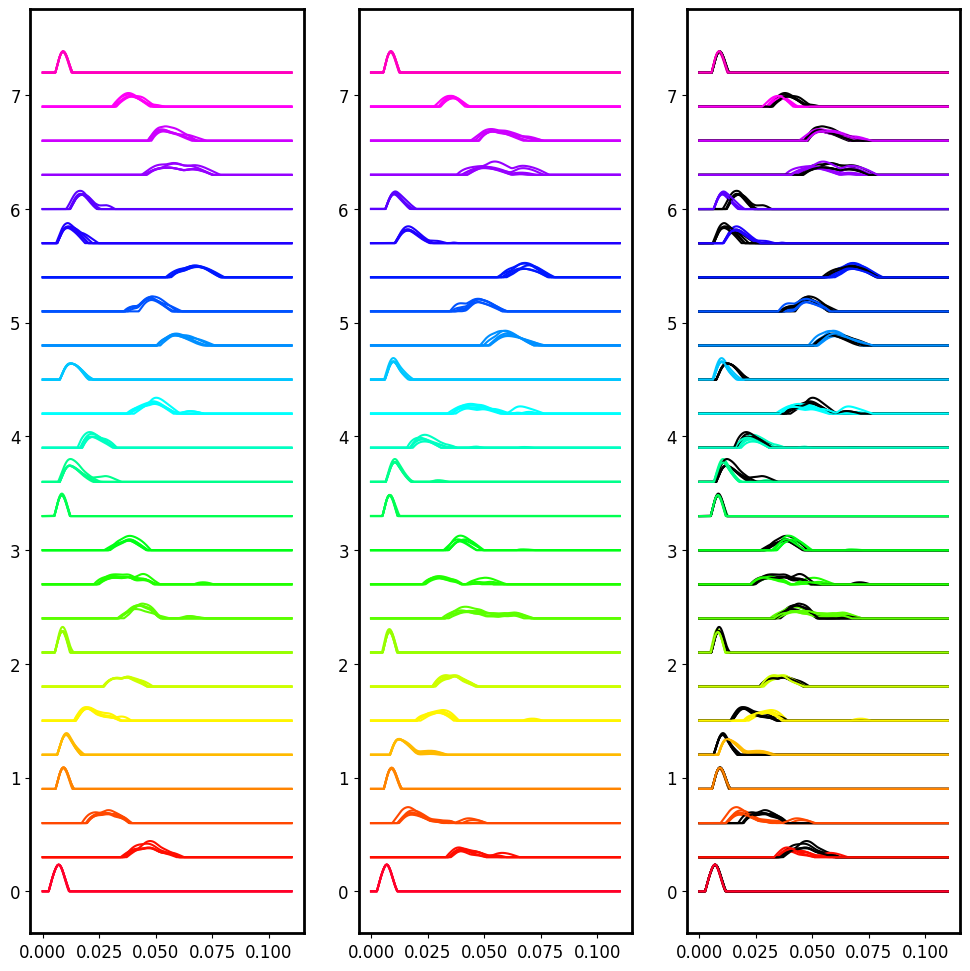

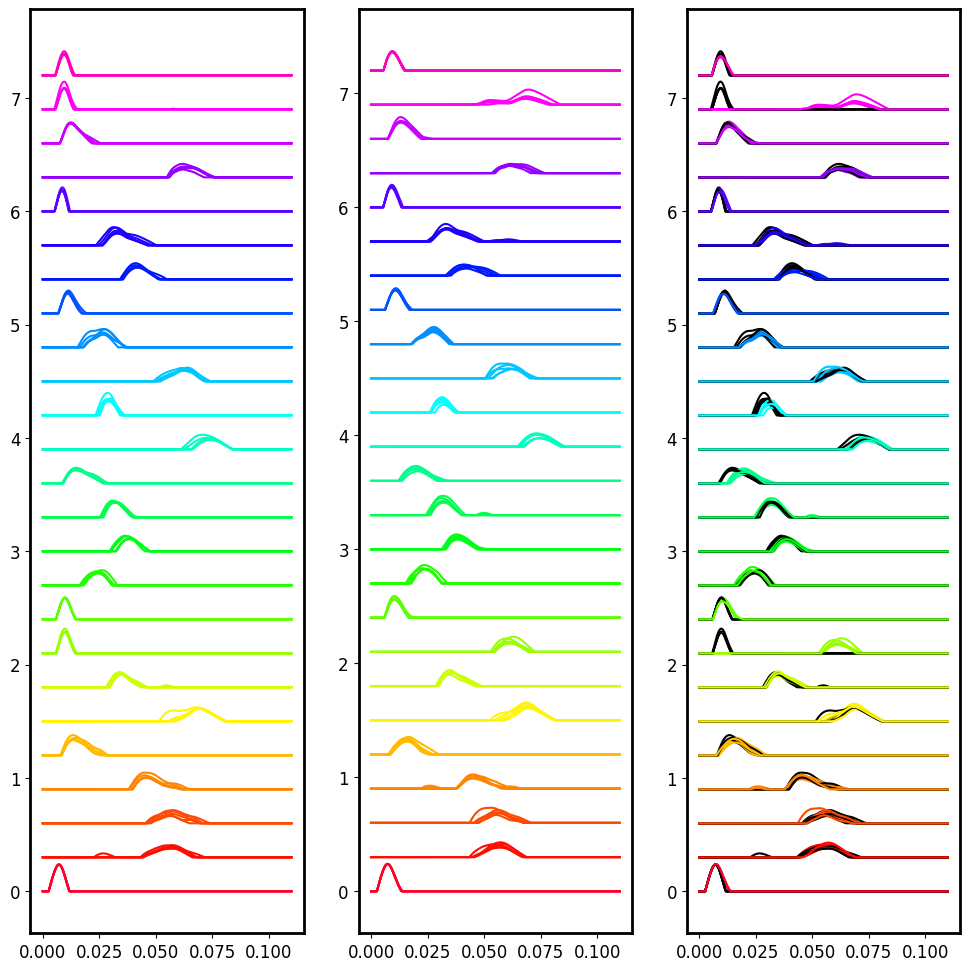

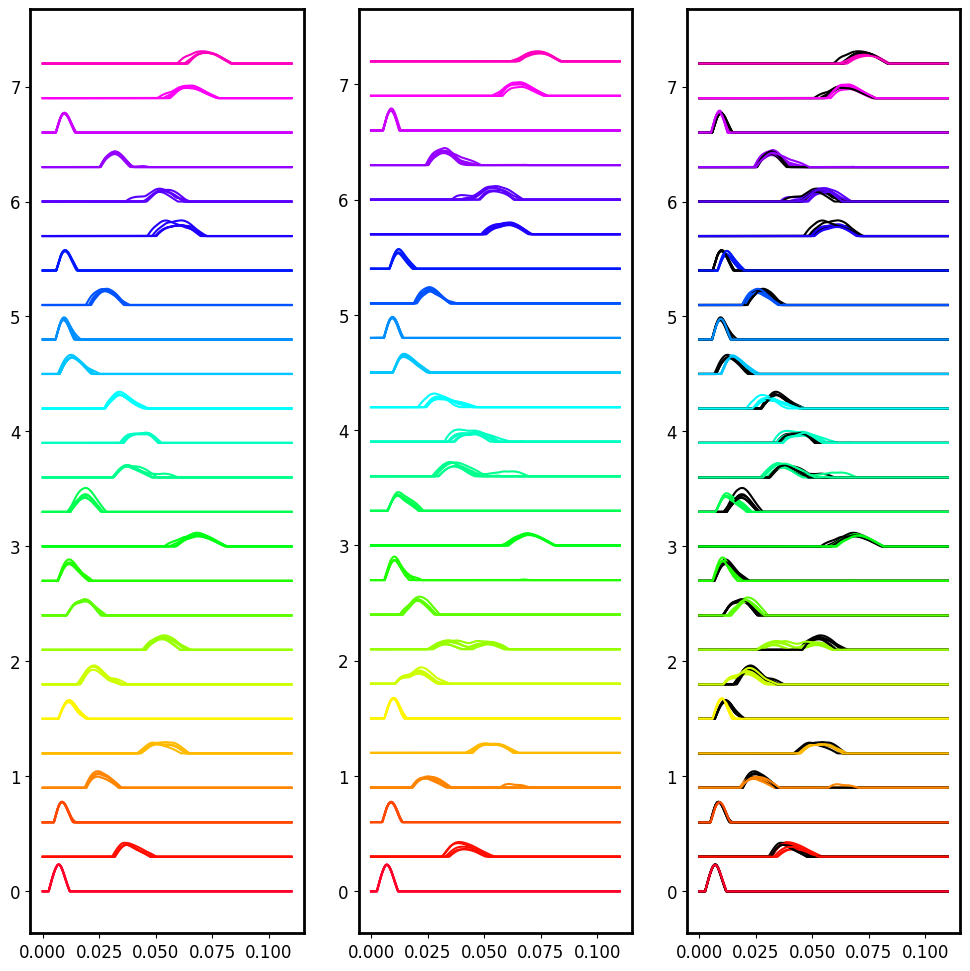

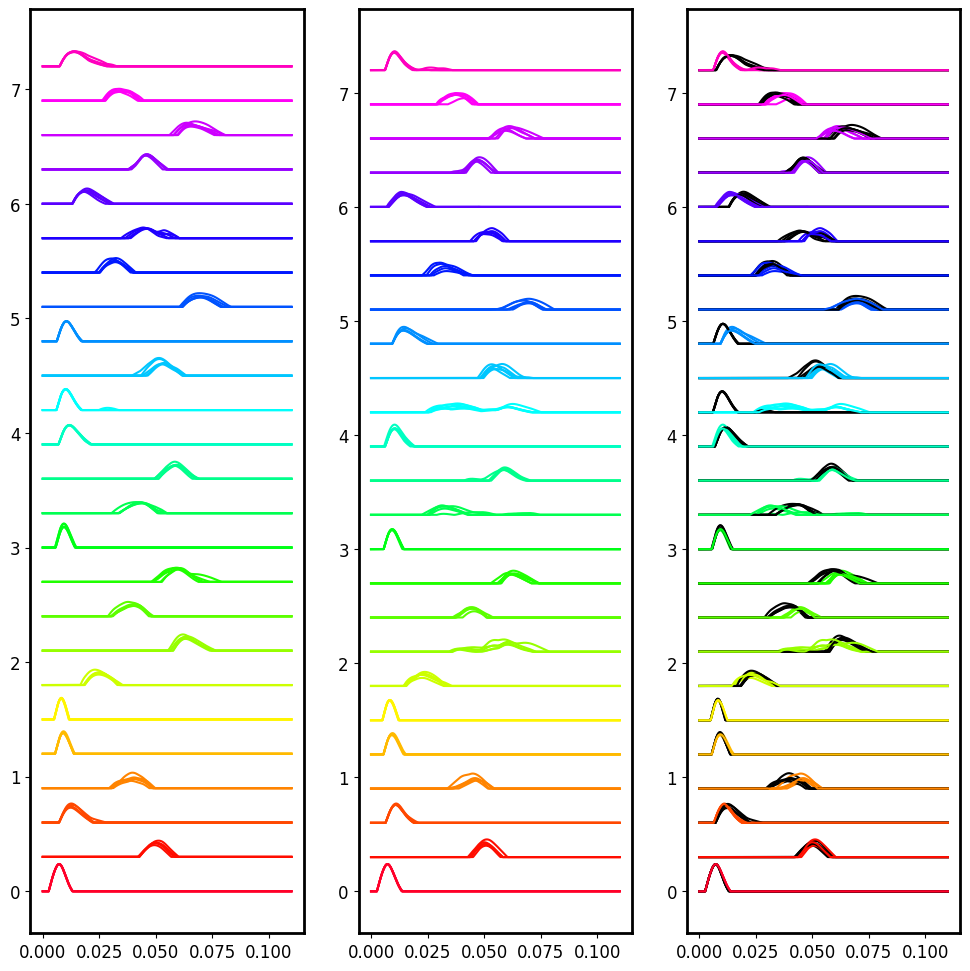

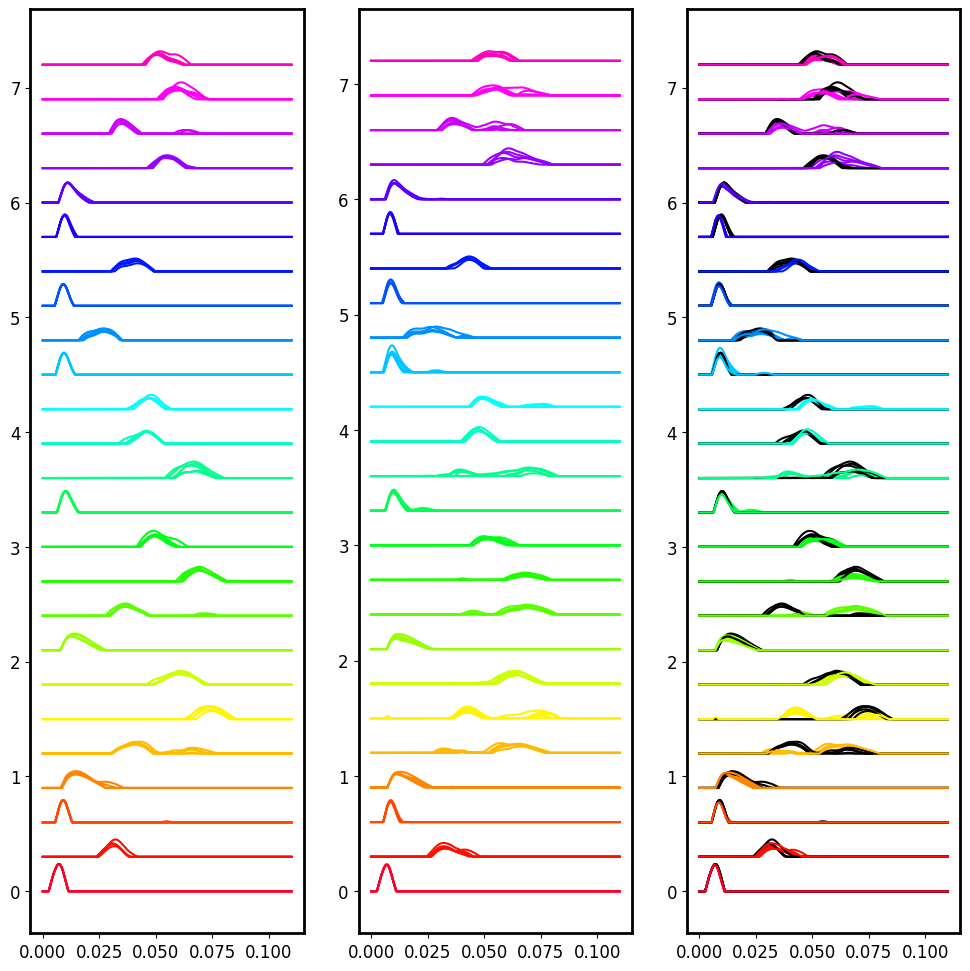

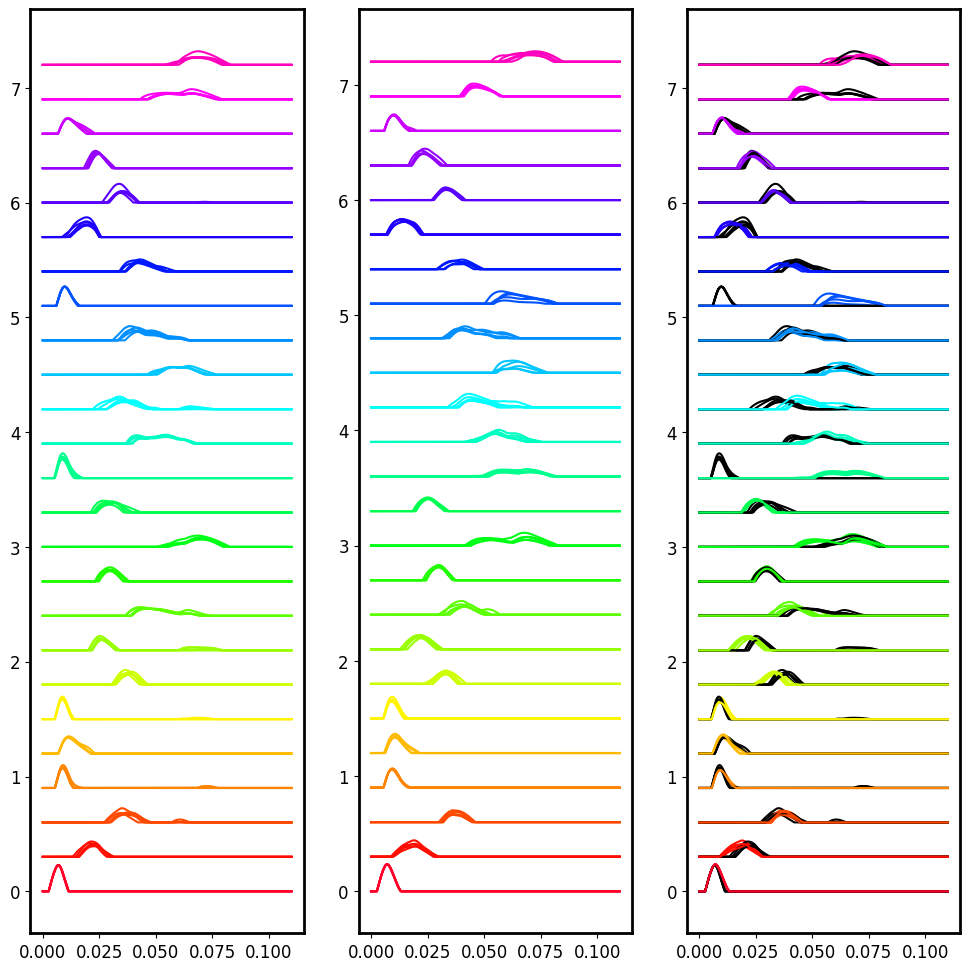

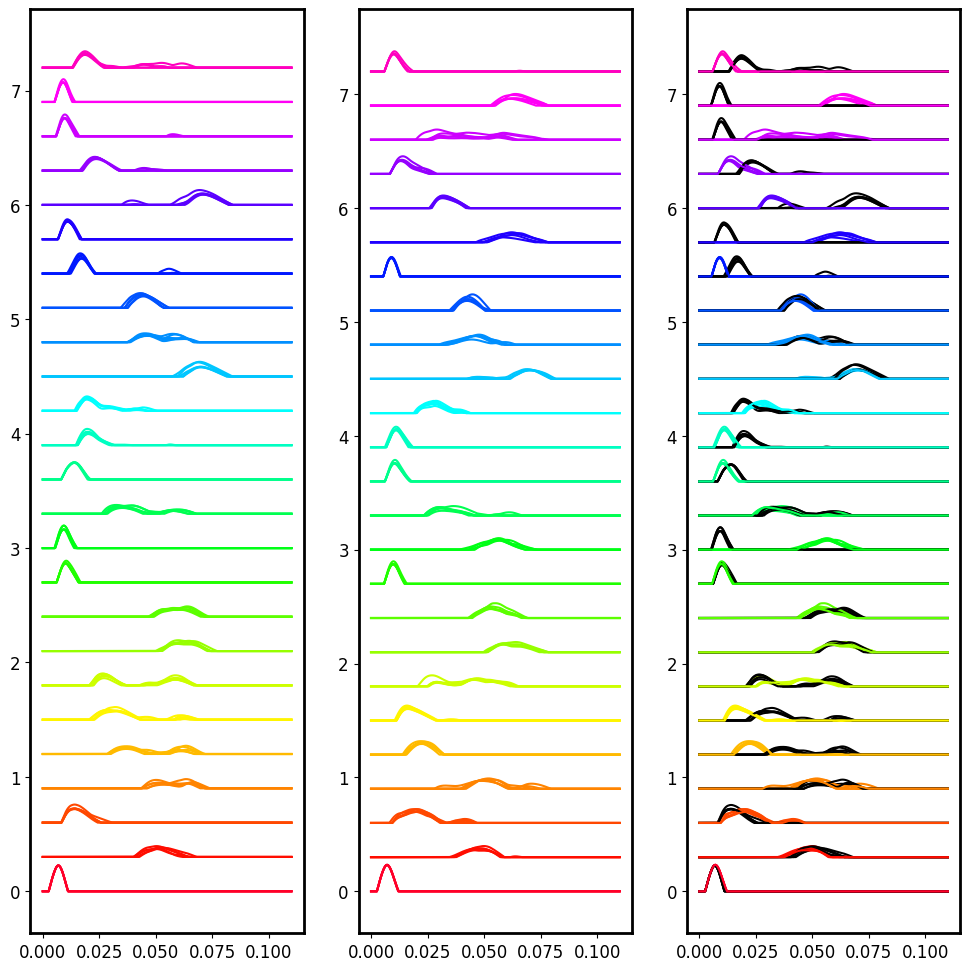

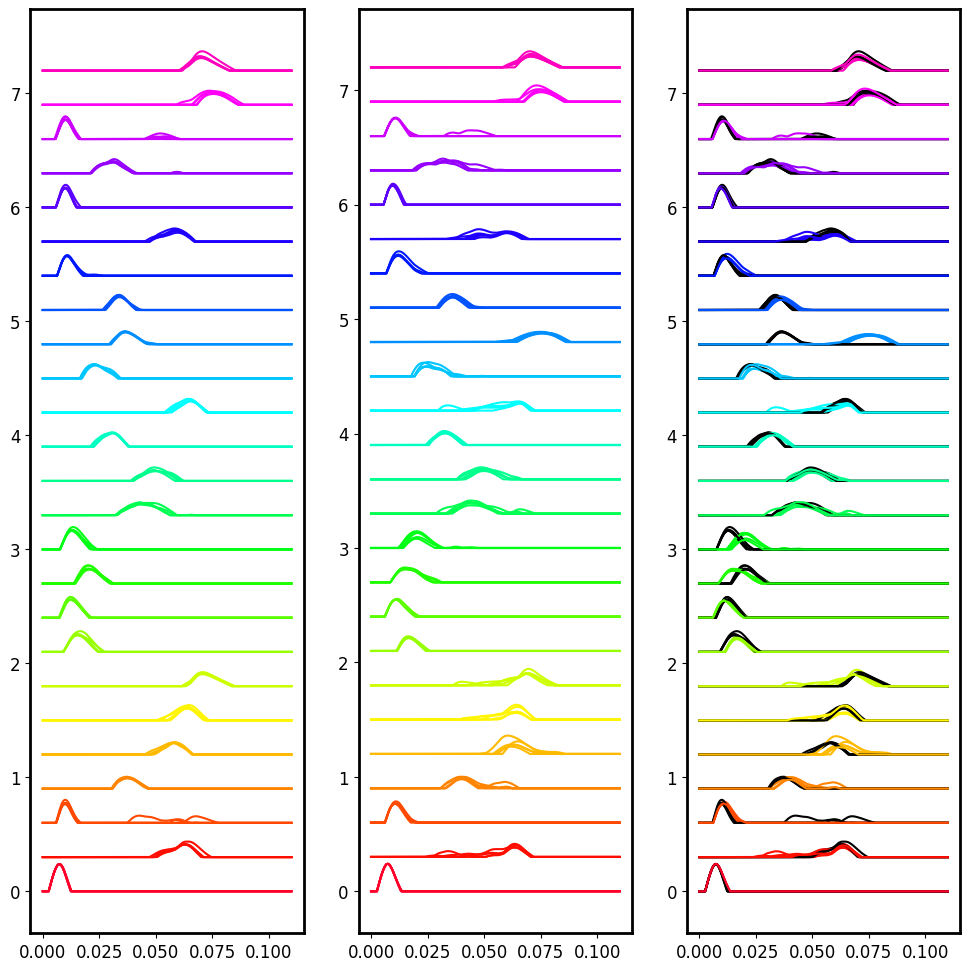

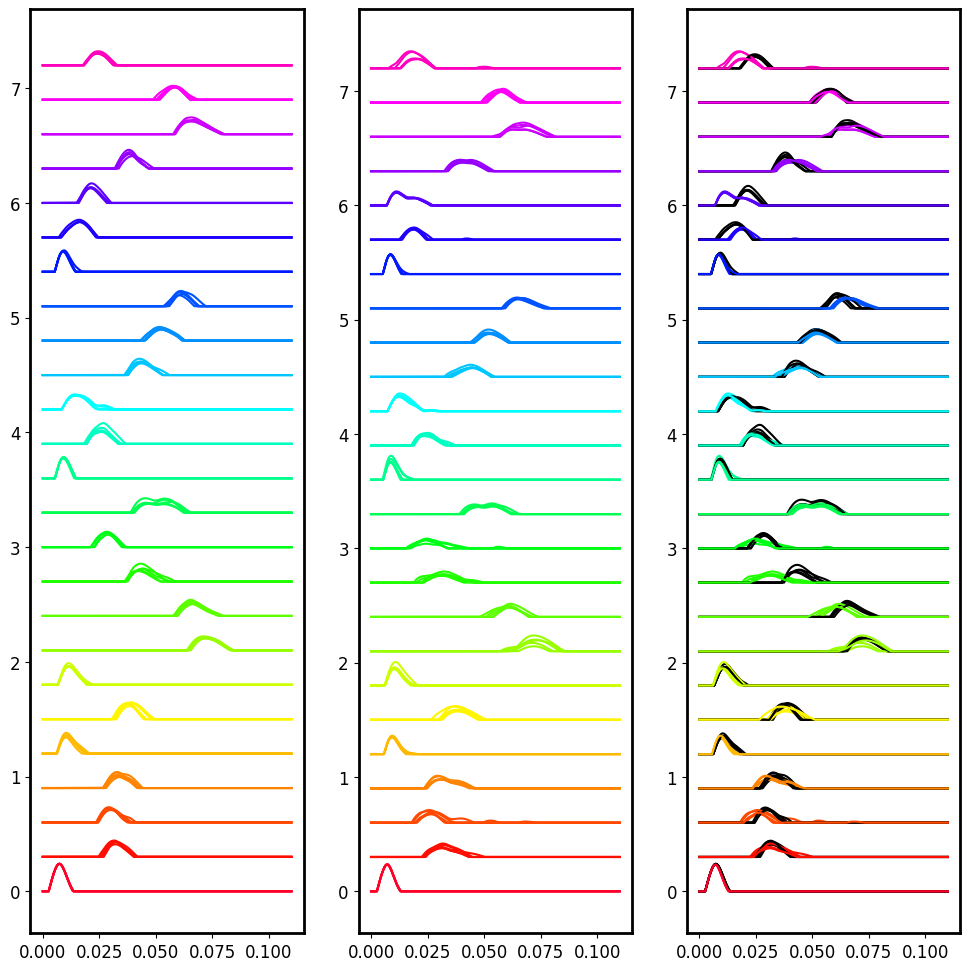

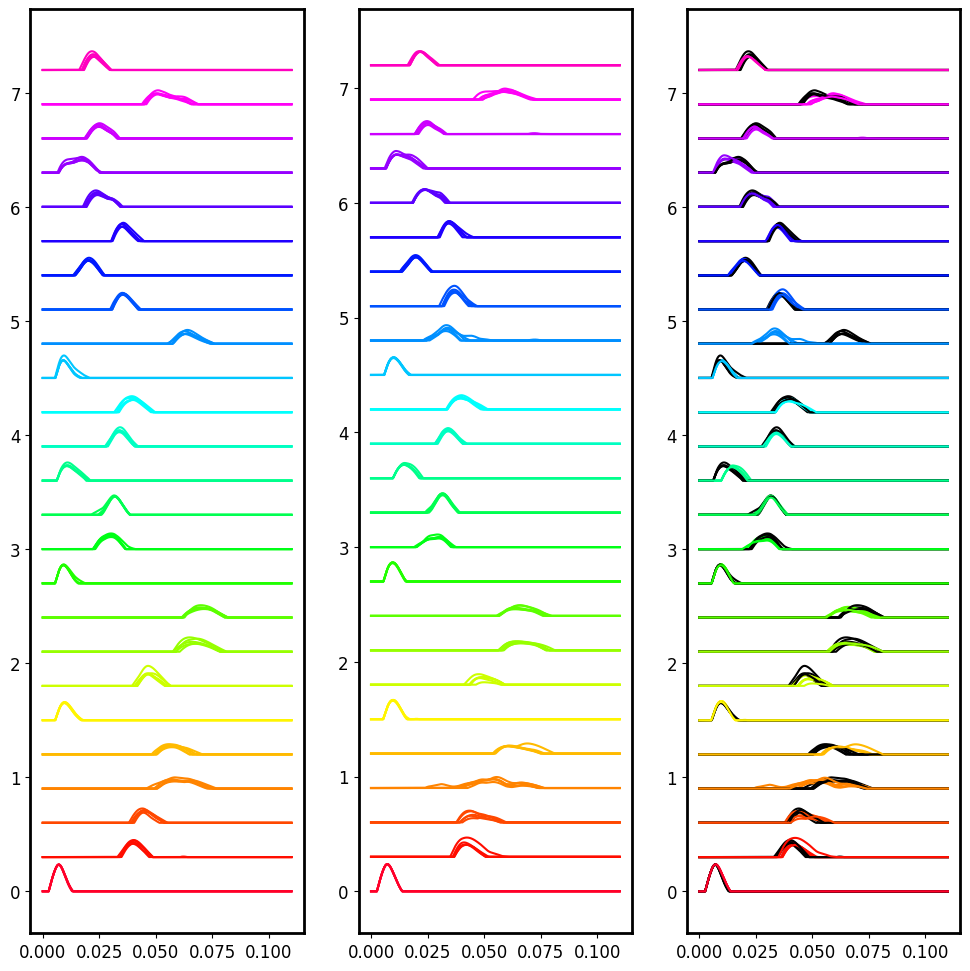

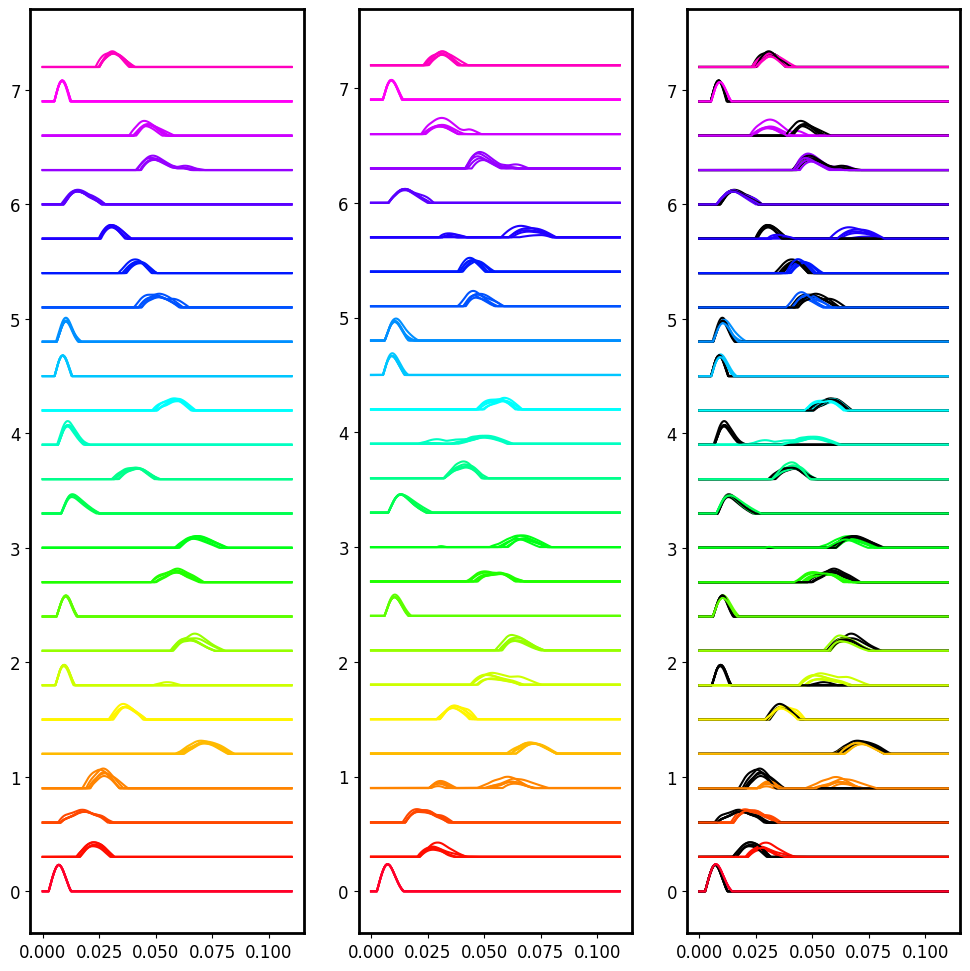

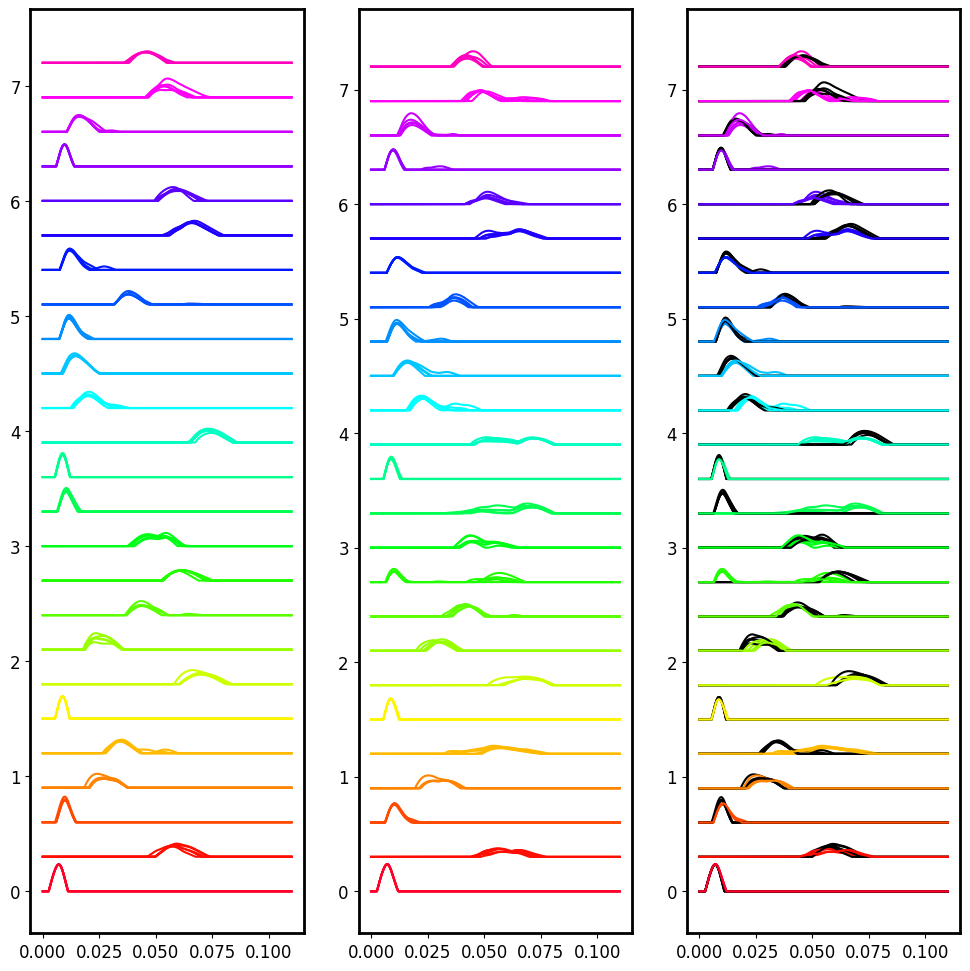

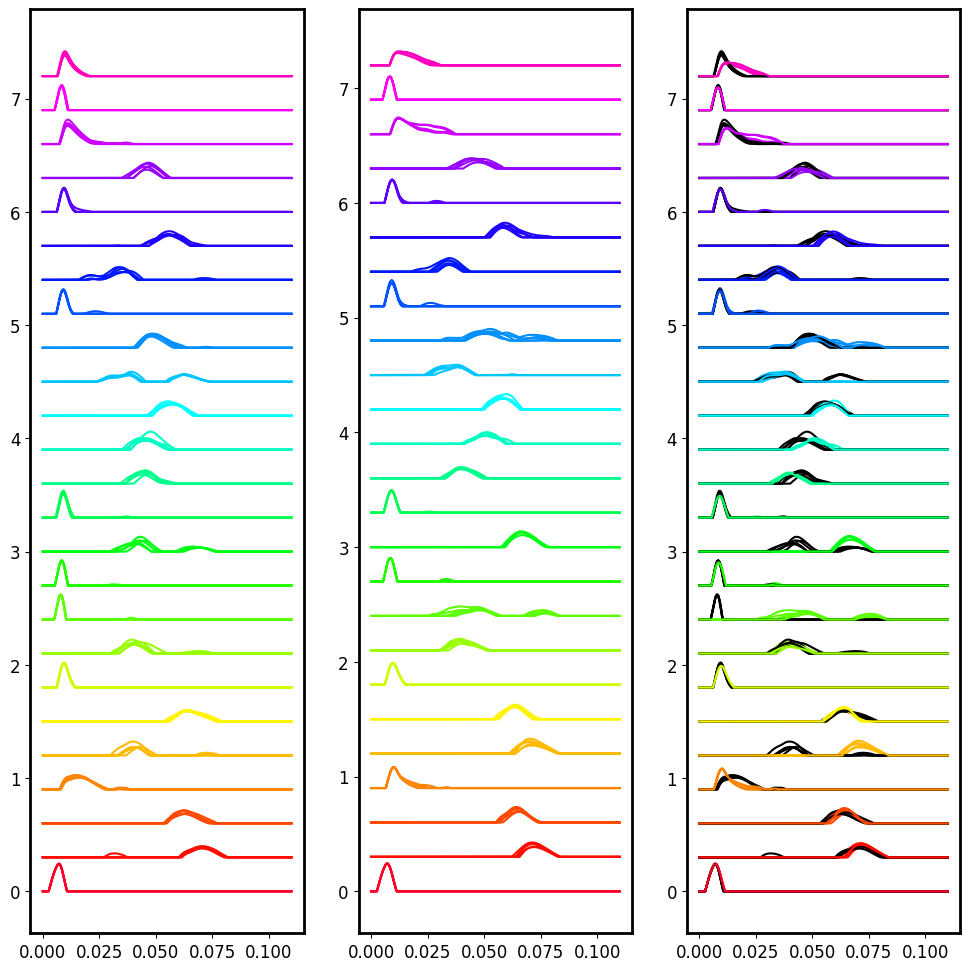

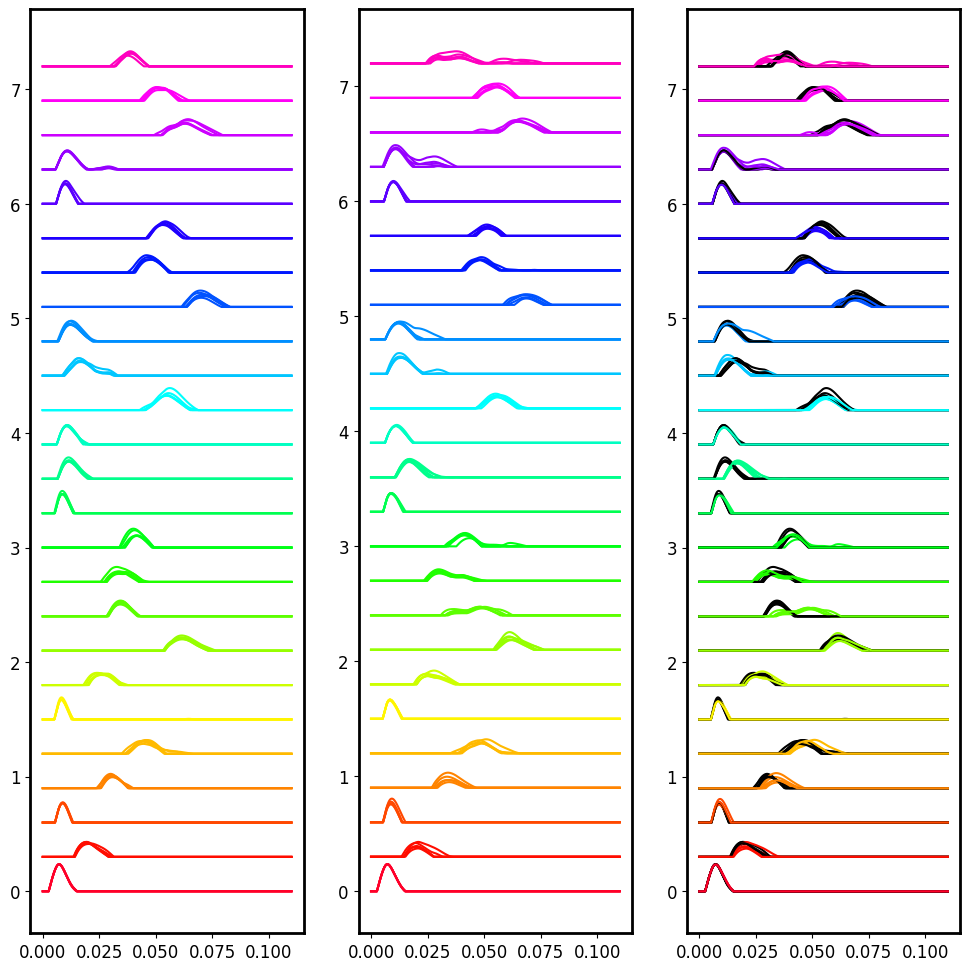

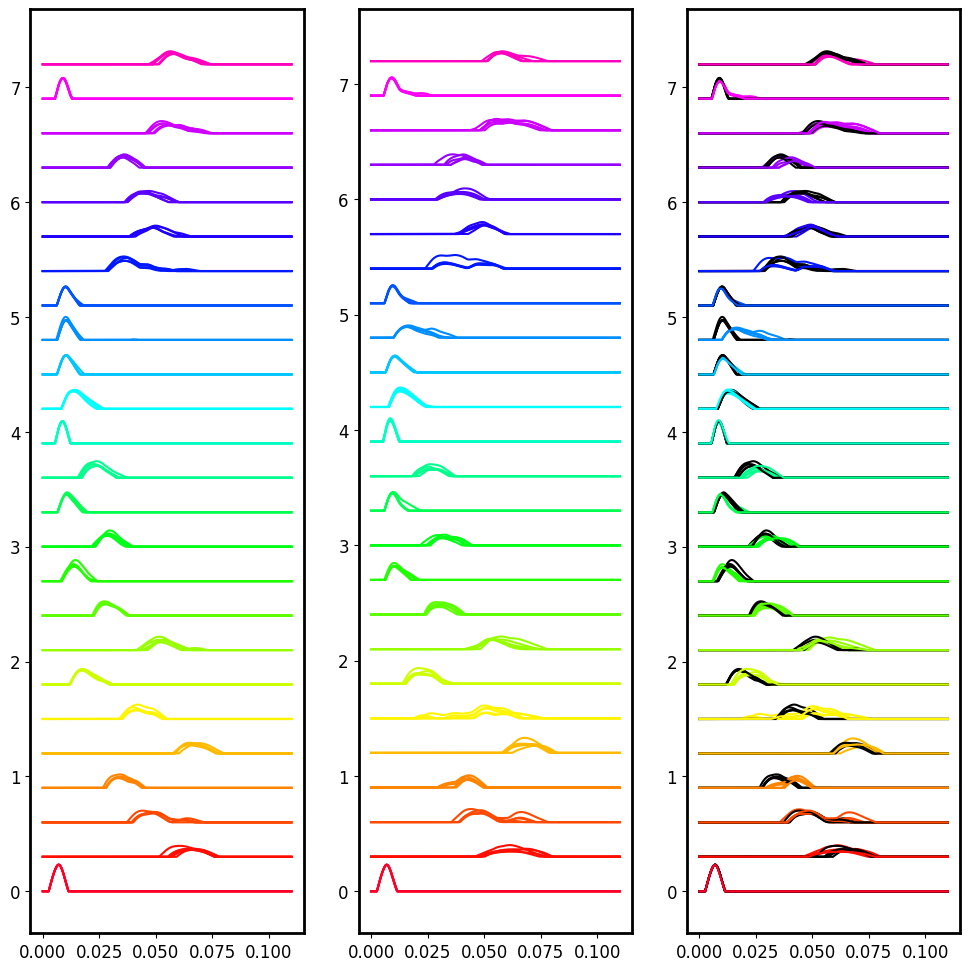

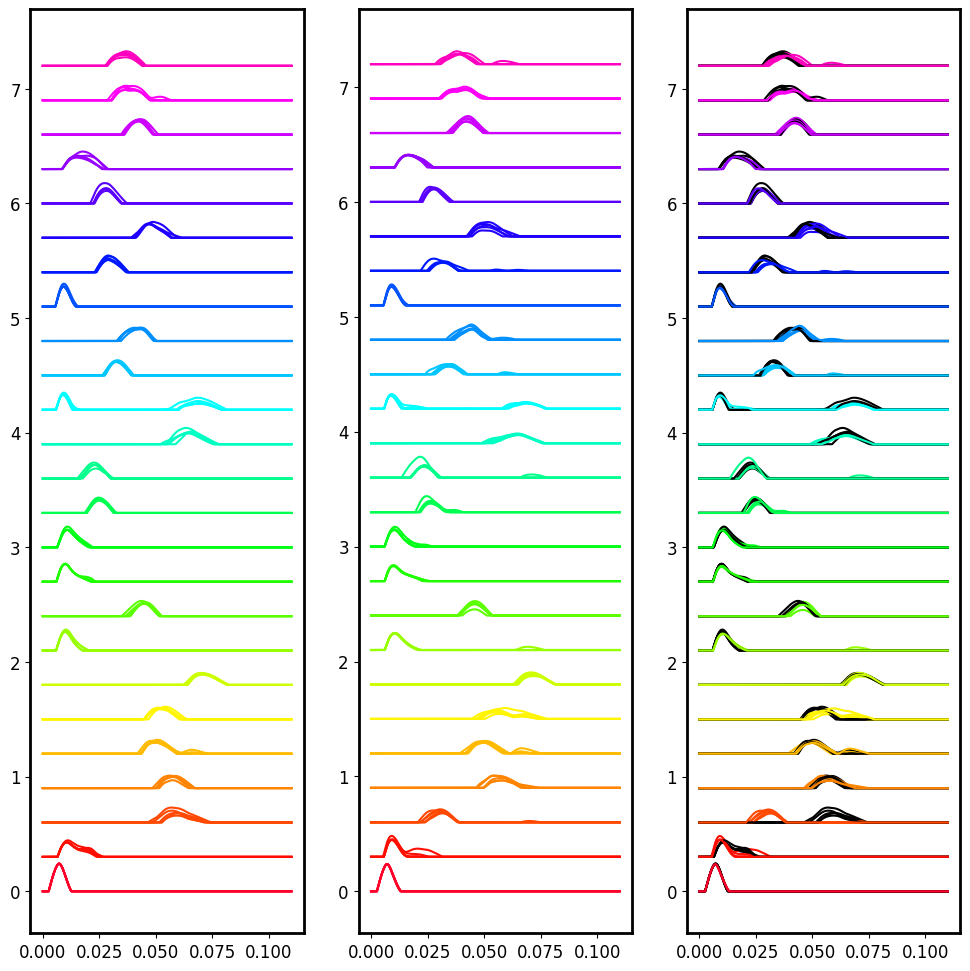

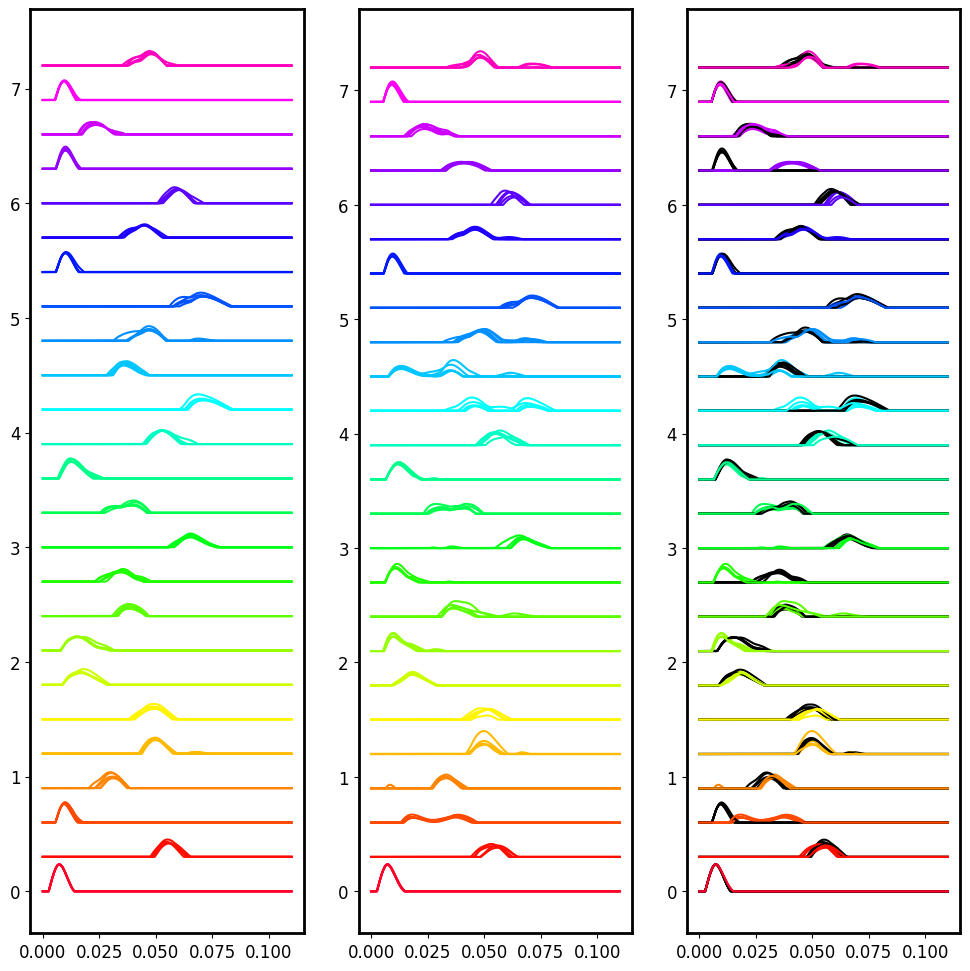

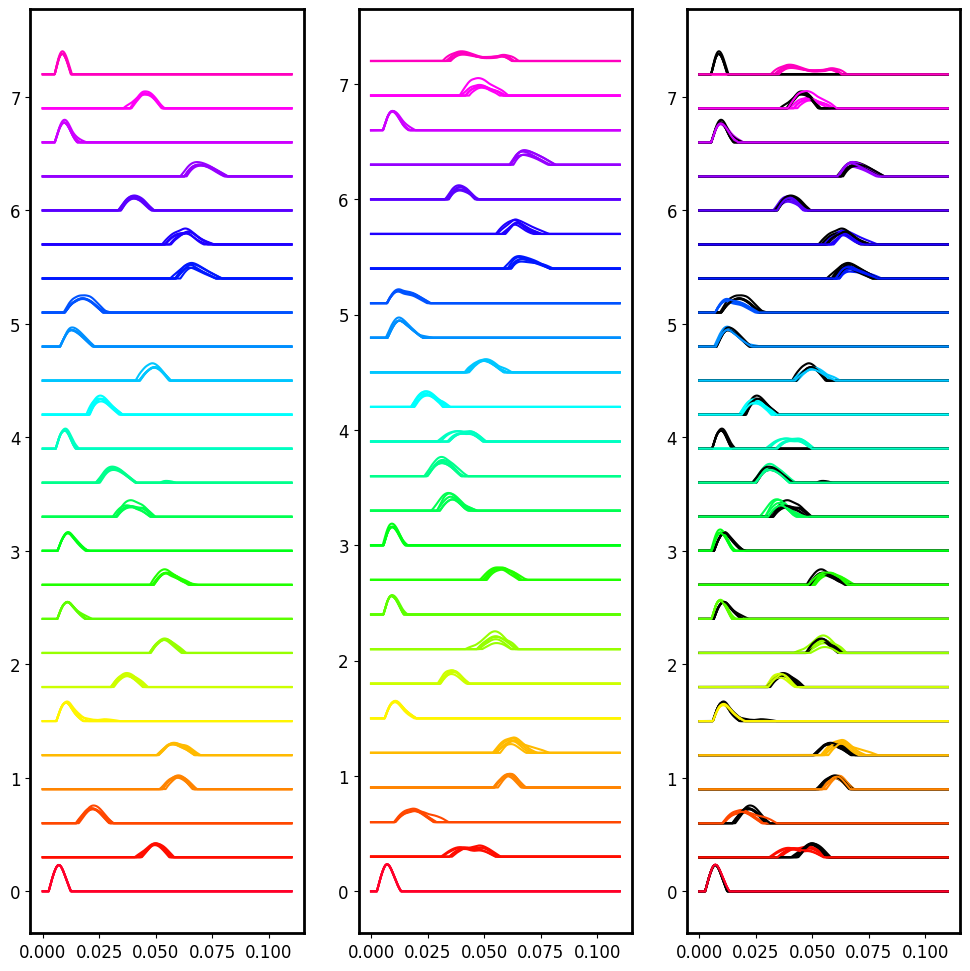

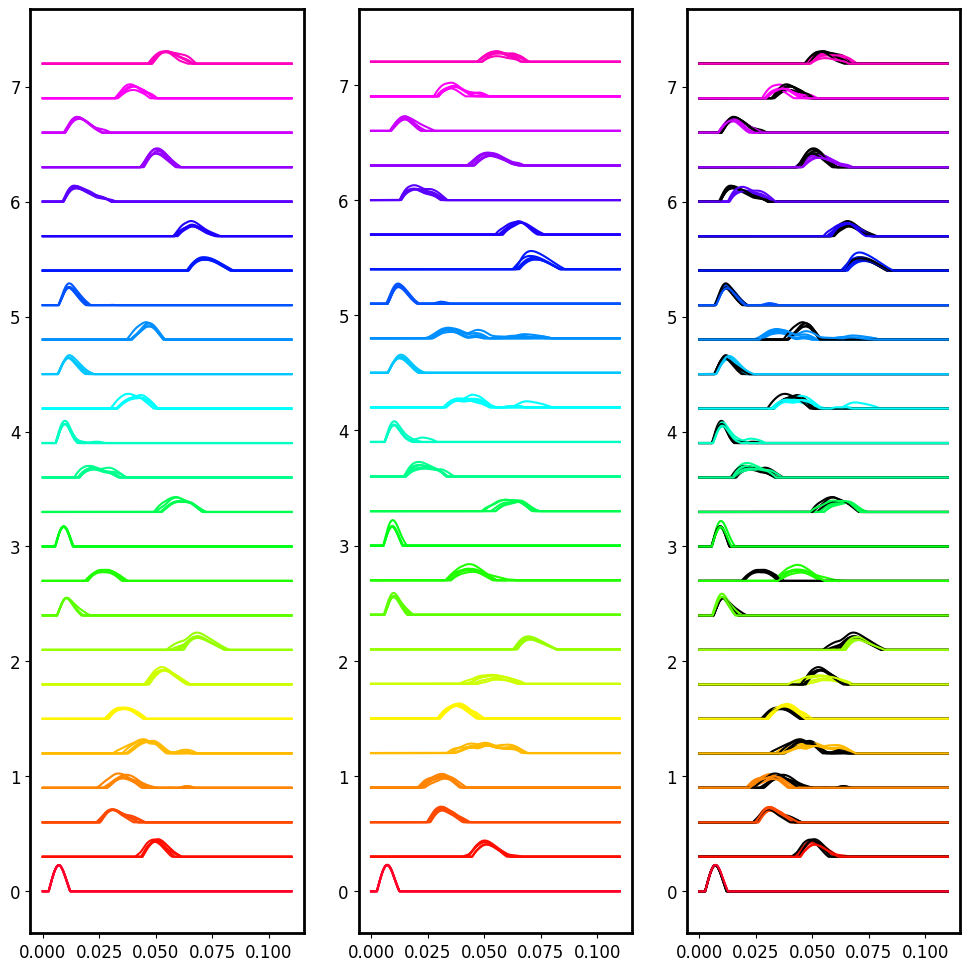

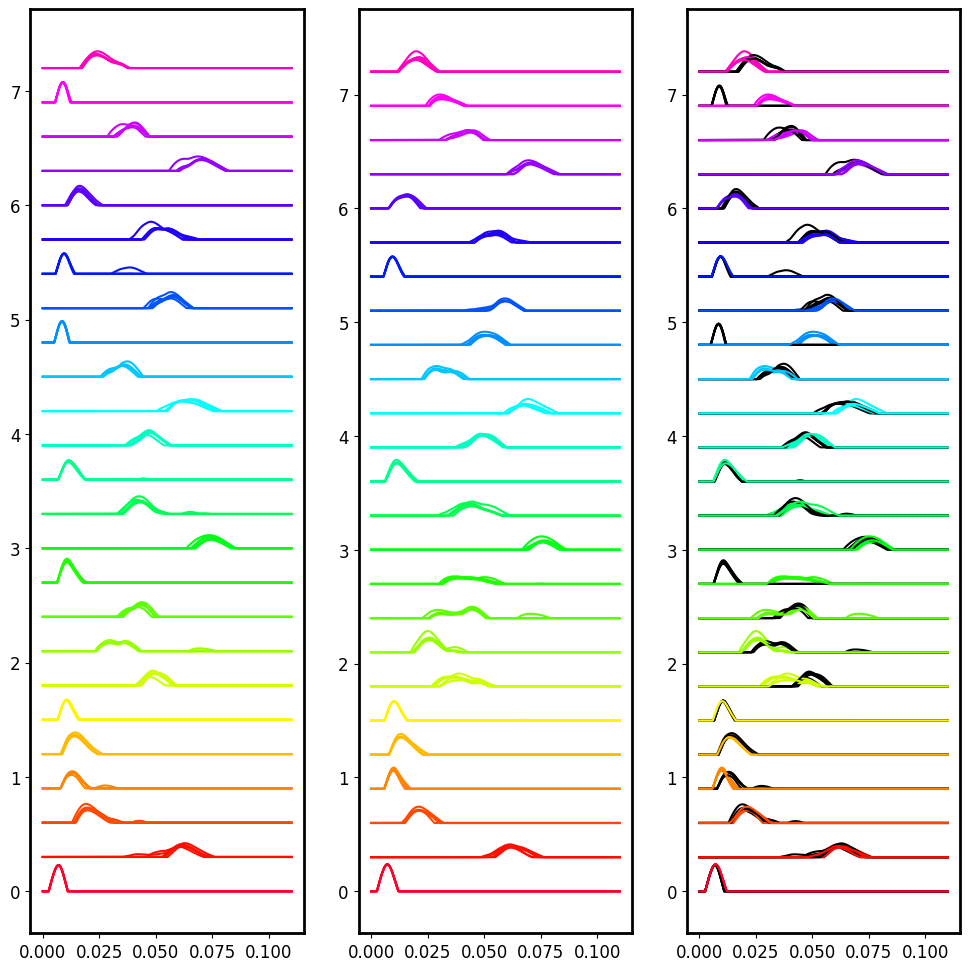

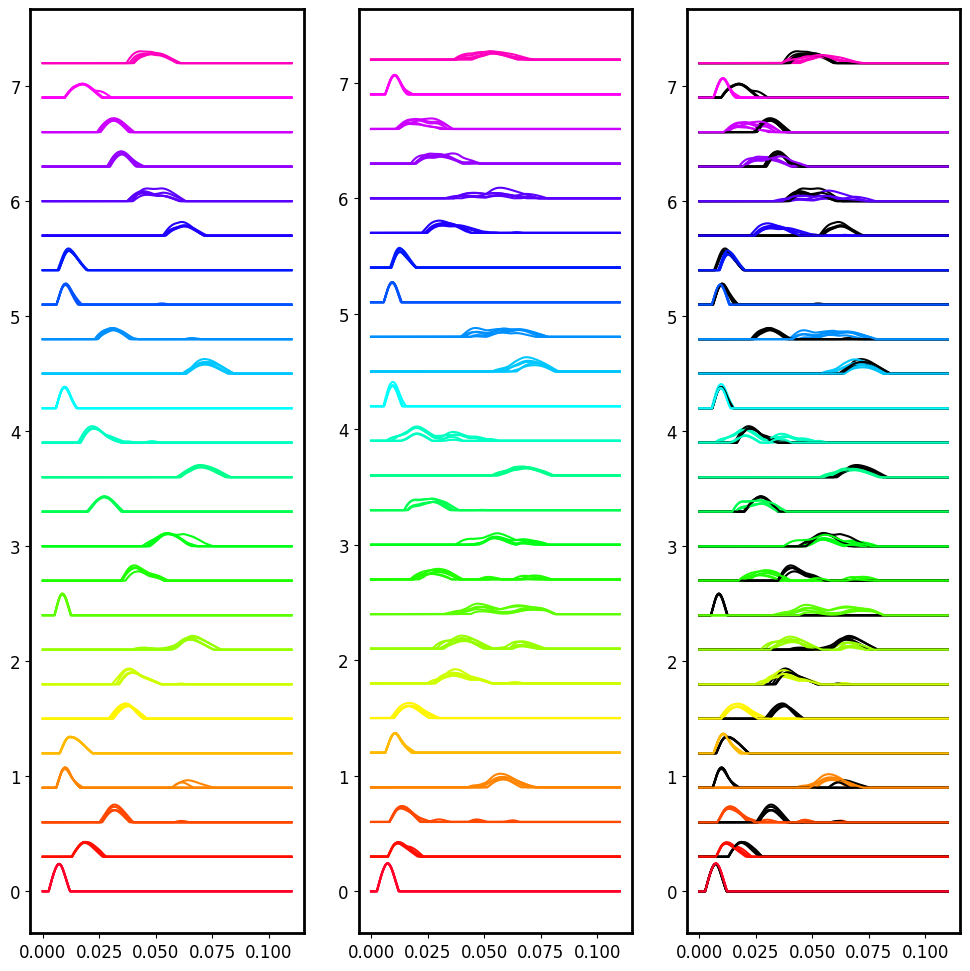

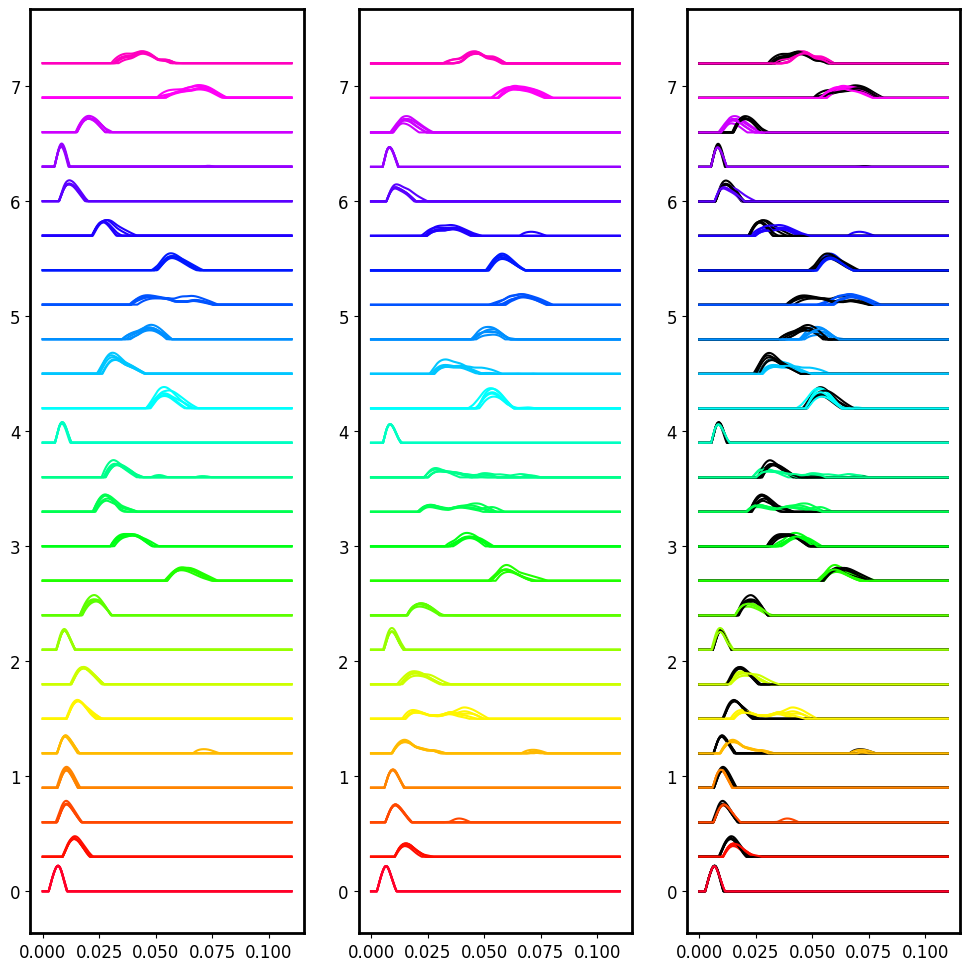

In [33]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.002_FRACI_0.75_SEED_51_2024-01-18_13:07:51.134876'
plot_activity([file_name], repeats=30)

In [3]:
def plot_all_losses(file_names, batch_size, colors=None, labels=None, scale=2):    
    cutoff = 300
    
    gs = gridspec.GridSpec(5, 1)
    fig = plt.figure(figsize=(4 * scale, 3.5 * scale), tight_layout=True)
    axs = [fig.add_subplot(gs[:2]), fig.add_subplot(gs[2:5])]
    
    axs[1].set_ylabel('Loss')
    axs[0].set_xticks([])
    axs[0].set_xlim(0, len(file_names) + 1)
    axs[0].set_xticklabels([])
#     axs[1].set_xticklabels(np.concatenate([np.arange(0, len(file_names)), ['All']]))
#     axs[1].set_xlabel('No. terms included')
    axs[1].set_xlim(0, len(file_names) + 1)
    axs[1].set_xticks(np.arange(len(file_names)) + 1)

    axs[0].set_yscale('log')
#     axs[0].set_ylim(cutoff * 0.5, 1e9)
    axs[1].set_ylim(0, cutoff * 1.1)
    if labels is None:
        labels = [''] + ['Summed\nsynaptic'] * 2 + ['Meta-learned'] * 2 + ['Meta-learned\nwith turnover'] * 2
    axs[1].set_xticklabels(labels, rotation=30)

    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    
    if colors is None:
        colors = ['black', 'green', 'black', 'green', 'black', 'green']
    
    for file_idx, file_name in enumerate(file_names):
        train_data_path = f'./sims_out/{file_name}/train_data.csv'

        df_train = read_csv(train_data_path, read_header=False)
        
        losses = df_train[df_train.columns[1]]
        
        losses = losses[losses < 5000]
        
        print(np.mean(losses), np.median(losses))
        print(len(losses))
        
        axs[1].scatter(
            (len(losses) * [file_idx + 1 - 0.2] + np.random.normal(size=len(losses), scale=0.08)),
            losses,
            marker='o',
            facecolor='none',
            edgecolor=colors[file_idx],
        )
        
        axs[1].errorbar([file_idx + 1 + 0.2],
                        [np.mean(losses)],
                        yerr=np.std(losses) / np.sqrt(100), color='black', capsize=4, linestyle='')
        
        axs[1].scatter([file_idx + 1 + 0.2], [np.mean(losses)], color='black')
        
    set_font_size(axs[0], 22)
    set_font_size(axs[1], 22)
#     fig.savefig('figures/stress_test_comp_ila.png')
#     fig.savefig('figures/stress_test_comp_ila.svg')

106.99129506042999 75.27145019235721
100
99.65735311843558 78.1278262133114
100
133.1152963508479 84.94067203873614
100
147.4818061865225 84.30384042952971
100
122.58222646397464 87.33756022525647
100
114.58988865752156 86.36985661656078
100
153.76849382882014 99.2715131561334
99
195.22067572576884 102.48245093360504
100
148.7051070129663 102.17965891760167
100
149.0789005201525 99.87747627751637
100
198.30826338883605 123.8343701981247
100
247.30136013308865 141.04029720725893
100


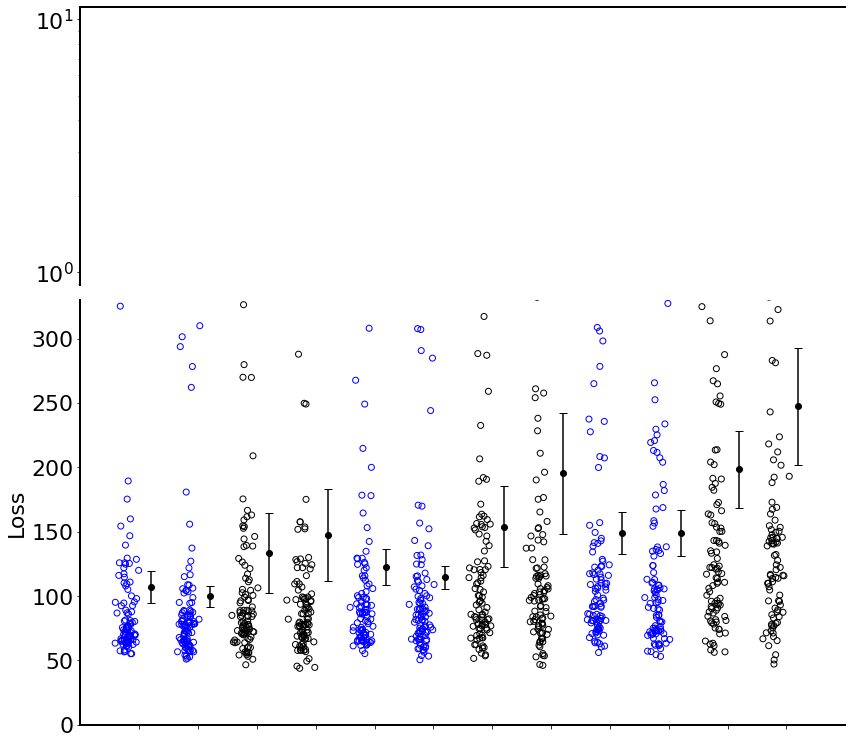

In [10]:
plot_all_losses([
    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-24_16:04:43.940266',
    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-25_09:22:02.447196',
    'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-25_15:06:41.151284',
    'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-25_14:10:29.061292',
#     'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-25_14:11:05.783392',

    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-24_16:35:45.468611',
    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-25_09:51:00.436011',
    'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-25_15:24:10.056563',
    'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-25_14:28:53.409331',
#     'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-25_14:32:52.309136',
    
    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-24_17:08:48.720329',
    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-25_10:18:36.163346',
    'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-25_15:41:43.256840',
    'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-25_14:47:03.134984',
#     'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-25_14:54:21.182982',
], 1, colors=['blue', 'blue', 'black', 'black'] * 3, labels=[''] * 12, scale=3)

In [117]:
def plot_all_losses_lines(file_names, batch_size, colors=None, labels=None, scale=2):    
    cutoff = 300
    
    gs = gridspec.GridSpec(5, 1)
    fig = plt.figure(figsize=(4 * scale, 3 * scale), tight_layout=True)
    axs = fig.add_subplot(gs[:])
    
    axs.set_ylabel('Loss')
#     axs.set_xlim(0, len(file_names) + 1)
    axs.set_xticks(np.arange(len(file_names)))
    
#     axs[0].set_ylim(cutoff * 0.5, 1e9)
#     axs.set_ylim(0, cutoff * 1.1)
    if labels is None:
        labels = [''] + ['Summed\nsynaptic'] * 2 + ['Meta-learned'] * 2 + ['Meta-learned\nwith turnover'] * 2
    axs.set_xticklabels(labels, rotation=30)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    
    if colors is None:
        colors = ['black', 'green', 'black', 'green', 'black', 'green']
        
    for file_group_idx, file_group in enumerate(file_names):
        
        idxs = []
        all_losses = []
    
        for file_idx, file_name in enumerate(file_group):
            train_data_path = f'./sims_out/{file_name}/train_data.csv'

            df_train = read_csv(train_data_path, read_header=False, delimiter=',')
            df_train = df_train.drop(index=0)

            losses = df_train[df_train.columns[1]]

            losses = losses[losses < 5000]

            print(np.mean(losses), np.median(losses))
            
            all_losses.append(losses)
            idxs.append(file_idx)
          
        means = np.array([np.mean(all_losses[j]) for j in range(len(all_losses))])
        stds = np.array([np.std(all_losses[j]) for j in range(len(all_losses))])
        
        axs.errorbar(np.array(idxs) + 1 + 0.1 * file_group_idx,
                        means,
                        yerr=stds / np.sqrt(100), color=colors[file_group_idx], capsize=4, linestyle='')

        axs.plot(np.array(idxs) + 1 + 0.1 * file_group_idx, means, color=colors[file_group_idx])
        axs.scatter(np.array(idxs) + 1 + 0.1 * file_group_idx, means, color=colors[file_group_idx])
        
    set_font_size(axs, 22)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (3).

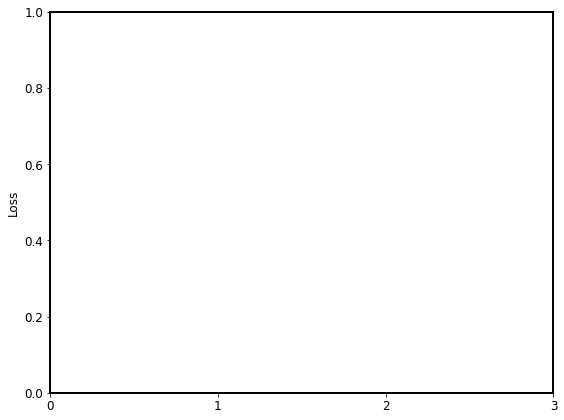

In [118]:
plot_all_losses_lines([
    [
        'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-24_16:04:43.940266',
        'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-24_16:35:45.468611',
        'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-24_17:08:48.720329',
    ],
    [
        'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-25_09:22:02.447196',
        'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-25_09:51:00.436011',
        'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-25_10:18:36.163346',
    ],
    [
        'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-25_15:06:41.151284',
        'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-25_15:24:10.056563',
        'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-25_15:41:43.256840',
    ],
    [
        'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00034_FRACI_0.75_SEED_1_2024-01-25_14:10:29.061292',
        'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0007_FRACI_0.75_SEED_1_2024-01-25_14:28:53.409331',
        'decoder_ee_mixed_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0011_FRACI_0.75_SEED_1_2024-01-25_14:47:03.134984',
    ],
], 1, colors=['blue', 'blue', 'black', 'black'], labels=['0.00034', '0.0007', '0.0011'], scale=2)